In [1]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from numpy import argmax
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from tqdm import tqdm
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV
import collections
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
import pandas as pd

In [2]:
import numpy as np

In [3]:
human_lombardo = pd.read_csv("../data/human_smiles_r_v3.csv")
human_lombardo = human_lombardo[human_lombardo["smiles_r"]!="Cannot_do"].reset_index(drop=True)

In [4]:
human_lombardo=  human_lombardo[["smiles_r","human_VDss_L_kg","human_CL_mL_min_kg", "human_fup", "human_mrt", "human_thalf"]]

for endpoint in ["human_VDss_L_kg","human_CL_mL_min_kg", "human_mrt", "human_thalf" ]:
    print("Transformed endpoint to log base 10")
    human_lombardo[endpoint] = np.log10(human_lombardo[endpoint])
human_lombardo

Transformed endpoint to log base 10
Transformed endpoint to log base 10
Transformed endpoint to log base 10
Transformed endpoint to log base 10


smiles_r  human_VDss_L_kg  \
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...         0.006466   
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1         1.079181   
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...        -0.275724   
3                             C#CC[NH+](C)C(C)Cc1ccccc1         0.278754   
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...         0.041393   
...                                                 ...              ...   
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2         0.556303   
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1         0.838849   
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1         0.612784   
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1         0.591065   
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2         0.518514   

      human_CL_mL_min_kg  human_fup  human_mrt  human_thalf  
0               0.638489       0.33   0.568202     1.176091  
1               0.949390        NaN   1.348305     1.705008  
2              -0.537602       0.01   1.482588     1.894870  
3               1.301030       0.13   0.204120     0.113943  
4               0.204120        NaN   1.068186     1.037426  
...                  ...        ...        ...          ...  
1278            0.903090        NaN   1.021189     0.913814  
1279            0.707570       0.35   1.361728     1.204120  
1280            0.934498       0.50   0.892095     0.863323  
1281            1.293804        NaN   0.537819     0.359835  
1282            1.000000        NaN   0.740363     0.623249  

[1283 rows x 6 columns]

In [5]:
human_lombardo = human_lombardo.groupby('smiles_r').median().reset_index()
human_lombardo

smiles_r  human_VDss_L_kg  \
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...         0.006466   
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1         1.079181   
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...        -0.275724   
3                             C#CC[NH+](C)C(C)Cc1ccccc1         0.278754   
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...         0.041393   
...                                                 ...              ...   
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2         0.556303   
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1         0.838849   
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1         0.612784   
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1         0.591065   
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2         0.518514   

      human_CL_mL_min_kg  human_fup  human_mrt  human_thalf  
0               0.638489       0.33   0.568202     1.176091  
1               0.949390        NaN   1.348305     1.705008  
2              -0.537602       0.01   1.482588     1.894870  
3               1.301030       0.13   0.204120     0.113943  
4               0.204120        NaN   1.068186     1.037426  
...                  ...        ...        ...          ...  
1278            0.903090        NaN   1.021189     0.913814  
1279            0.707570       0.35   1.361728     1.204120  
1280            0.934498       0.50   0.892095     0.863323  
1281            1.293804        NaN   0.537819     0.359835  
1282            1.000000        NaN   0.740363     0.623249  

[1283 rows x 6 columns]

In [6]:
human_smiles_r = human_lombardo[["smiles_r"]]
human_smiles_r

smiles_r
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...
3                             C#CC[NH+](C)C(C)Cc1ccccc1
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...
...                                                 ...
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2

[1283 rows x 1 columns]

In [7]:
from sklearn.feature_selection import VarianceThreshold
from itertools import compress
    
def count(pred, true, min, max, endpoint):

    if(endpoint == "human_fup"):
        lst = [abs(a/b) for a, b in zip(pred, true)]
        #print(lst)

        newlist = [x for x in lst if min <= x <= max]
        #print(newlist)

        return (len(newlist)/len(lst)) *100
    
    else:
        lst = [abs(10**a/10**b) for a, b in zip(pred, true)]
        #print(lst)

        newlist = [x for x in lst if min <= x <= max]
        #print(newlist)

        return (len(newlist)/len(lst)) *100
    
    return

def calc_gmfe(pred, true, endpoint):
    
    if(endpoint == "human_fup"):
        
        lst = [abs(np.log10(a/b)) for a, b in zip(pred, true)]
        mean_abs= np.mean(lst)
        return (10**mean_abs)
    
    else: 
        lst = [abs(np.log10(10**a/10**b)) for a, b in zip(pred, true)]
        mean_abs= np.mean(lst)
        
        return (10** mean_abs)
    
    return
                         
def median_fold_change_error(pred, true, endpoint):
                         
    if (endpoint == "human_fup"):
        lst = [abs(np.log10(a/b)) for a, b in zip(pred, true)]
        median_abs= np.median(lst) 
        return (np.e**median_abs)
    
    else:
        lst = [abs(np.log10(10**a/10**b)) for a, b in zip(pred, true)]
        median_abs= np.median(lst) 
        return (np.e**median_abs)
    
    return
                          
def calc_bias(pred, true, endpoint):
                          
    if (endpoint == "human_fup"):
        lst = [(a - b) for a, b in zip(pred, true)]                 
        bias= np.median(lst)
        return bias
    
    else:
        lst = [(10**a - 10**b) for a, b in zip(pred, true)]                 
        bias= np.median(lst)
        return bias
    
    return

In [8]:
from rdkit import Chem
from mordred import Calculator, descriptors

# create descriptor calculator with all descriptors
calc = Calculator(descriptors, ignore_3D=True)

print(len(calc.descriptors))

Ser_Mol = human_lombardo['smiles_r'].apply(Chem.MolFromSmiles)

# as pandas
Mordred_table=  calc.pandas(Ser_Mol)

1613


  1%|▌                                        | 18/1283 [00:01<01:38, 12.83it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  2%|▋                                        | 20/1283 [00:02<02:08,  9.84it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 19%|███████▋                                | 248/1283 [00:04<00:11, 88.73it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, ax

 22%|████████▌                              | 281/1283 [00:04<00:07, 129.00it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 23%|█████████                              | 298/1283 [00:04<00:09, 100.32it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 32%|████████████▋                           | 407/1283 [00:06<00:13, 64.24it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 40%|███████████████▊                        | 508/1283 [00:06<00:10, 76.47it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 40%|███████████████▊                       | 519/1283 [00:06<00:05, 141.36it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 45%|█████████████████▌                     | 577/1283 [00:07<00:04, 151.17it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 48%|███████████████████▎                    | 619/1283 [00:08<00:11, 55.63it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 56%|██████████████████████▌                 | 722/1283 [00:09<00:07, 79.65it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 80%|██████████████████████████████▎       | 1022/1283 [00:11<00:01, 161.67it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|█████████████████████████████████████▊| 1277/1283 [00:12<00:00, 183.29it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|███████████████████████████████████████| 1283/1283 [00:12<00:00, 99.84it/s]


/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [9]:
Mordred_table = Mordred_table.astype('float')
Mordred_table['smiles_r'] = human_lombardo['smiles_r']
Mordred_table

ABC      ABCGG  nAcid  nBase    SpAbs_A   SpMax_A  SpDiam_A  \
0     26.726479  20.199330    2.0    0.0  43.712035  2.420516  4.841033   
1     16.484101  15.092007    1.0    0.0  24.810570  2.476291  4.952581   
2     30.181133  23.132813    4.0    0.0  49.053928  2.449016  4.898018   
3     10.077834   9.321842    0.0    1.0  17.214150  2.226811  4.453621   
4     14.384684  13.322169    0.0    0.0  23.623048  2.530742  4.897943   
...         ...        ...    ...    ...        ...       ...       ...   
1278  12.606602  10.129166    0.0    1.0  22.084432  2.412947  4.825894   
1279  14.018917  11.675935    0.0    1.0  24.741115  2.478172  4.956344   
1280  16.038187  14.420804    0.0    2.0  27.701443  2.658726  5.024986   
1281  15.515909  12.987974    0.0    2.0  26.938755  2.326623  4.635214   
1282  11.939935   9.906091    0.0    2.0  20.559285  2.387450  4.754235   

         SpAD_A   SpMAD_A   LogEE_A  ...     TSRW10          MW       AMW  \
0     43.712035  1.248915  4.459804  ...  71.132315  475.161514  8.485027   
1     24.810570  1.127753  3.981521  ...  56.111877  299.201654  6.106156   
2     49.053928  1.257793  4.581296  ...  89.010877  529.176450  8.675024   
3     17.214150  1.229582  3.514311  ...  44.372474  188.143376  5.879480   
4     23.623048  1.243318  3.870813  ...  67.418049  267.085521  8.346423   
...         ...       ...       ...  ...        ...         ...       ...   
1278  22.084432  1.380277  3.723828  ...  48.647579  221.128454  6.700862   
1279  24.741115  1.374506  3.833767  ...  51.418286  244.205976  5.550136   
1280  27.701443  1.385072  3.997563  ...  75.593926  263.154275  6.747546   
1281  26.938755  1.346938  3.923960  ...  66.060685  266.165174  6.654129   
1282  20.559285  1.370619  3.669040  ...  60.402256  205.097154  7.324898   

       WPath  WPol  Zagreb1  Zagreb2   mZagreb1  mZagreb2  \
0     4344.0  54.0    176.0    202.0  13.083333  7.805556   
1     1036.0  34.0    110.0    125.0  11.180556  4.750000   
2     5657.0  62.0    202.0    236.0  13.805556  8.611111   
3      337.0  16.0     62.0     67.0   5.333333  3.361111   
4      654.0  34.0    100.0    122.0   8.229167  4.291667   
...      ...   ...      ...      ...        ...       ...   
1278   412.0  24.0     84.0     99.0   3.444444  3.583333   
1279   549.0  29.0     94.0    112.0   4.034722  4.083333   
1280   751.0  30.0    112.0    139.0   4.256944  4.402778   
1281   829.0  24.0    100.0    113.0   4.444444  4.527778   
1282   359.0  20.0     80.0     94.0   3.194444  3.305556   

                                               smiles_r  
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...  
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1  
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...  
3                             C#CC[NH+](C)C(C)Cc1ccccc1  
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...  
...                                                 ...  
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2  
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1  
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1  
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1  
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2  

[1283 rows x 1614 columns]

In [10]:
len(Mordred_table.columns[Mordred_table.isna().any()].tolist())

441

In [11]:
Ser_Mol = human_lombardo['smiles_r'].apply(Chem.MolFromSmiles)

import numpy as np
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect

Morgan_fingerprint= Ser_Mol.apply(GetMorganFingerprintAsBitVect, args=(2, 2048))
Morganfingerprint_array  = np.stack(Morgan_fingerprint)

Morgan_collection  = []
for x in np.arange(Morganfingerprint_array.shape[1]): #np.arange plus rapide que range
    x = "Mfp"+str(x)
    Morgan_collection.append(x)

Morganfingerprint_table  = pd.DataFrame(Morganfingerprint_array , columns=Morgan_collection )
Morganfingerprint_table['smiles_r'] = human_lombardo['smiles_r']
Morganfingerprint_table

Mfp0  Mfp1  Mfp2  Mfp3  Mfp4  Mfp5  Mfp6  Mfp7  Mfp8  Mfp9  ...  \
0        0     1     0     0     0     0     0     0     0     0  ...   
1        0     0     0     0     0     0     0     0     0     0  ...   
2        0     1     0     0     0     0     0     0     0     0  ...   
3        0     1     0     0     1     0     0     0     0     0  ...   
4        0     0     0     0     0     0     0     0     0     0  ...   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
1278     0     0     0     0     0     0     0     0     0     0  ...   
1279     0     0     1     0     0     0     0     0     0     0  ...   
1280     0     0     0     0     0     0     0     0     0     0  ...   
1281     0     0     0     0     0     0     0     0     0     0  ...   
1282     0     0     0     0     0     0     0     0     0     0  ...   

      Mfp2039  Mfp2040  Mfp2041  Mfp2042  Mfp2043  Mfp2044  Mfp2045  Mfp2046  \
0           0        0        0        0        0        0        0        0   
1           0        0        0        0        0        0        0        0   
2           0        0        0        0        0        0        0        0   
3           0        0        0        0        0        0        0        0   
4           0        0        0        1        0        0        0        0   
...       ...      ...      ...      ...      ...      ...      ...      ...   
1278        0        0        0        0        0        0        0        0   
1279        0        0        0        0        0        0        0        0   
1280        0        0        0        0        0        0        0        0   
1281        0        0        0        0        0        0        0        0   
1282        0        0        0        0        0        0        0        0   

      Mfp2047                                           smiles_r  
0           0  C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...  
1           0      C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1  
2           0  C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...  
3           0                          C#CC[NH+](C)C(C)Cc1ccccc1  
4           0  C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...  
...       ...                                                ...  
1278        0                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2  
1279        0                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1  
1280        0              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1  
1281        0                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1  
1282        0                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2  

[1283 rows x 2049 columns]

In [12]:
human_lombardo_mfp = pd.merge(human_lombardo, Morganfingerprint_table)
human_lombardo_mfp_Mordred = pd.merge(human_lombardo_mfp, Mordred_table)
human_lombardo_mfp_Mordred

#human_lombardo_mfp = pd.merge(human_lombardo, Morganfingerprint_table)
#human_lombardo_mfp_Mordred = pd.merge(human_lombardo_mfp, Mordred_table)
#human_lombardo_mfp_Mordred

smiles_r  human_VDss_L_kg  \
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...         0.006466   
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1         1.079181   
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...        -0.275724   
3                             C#CC[NH+](C)C(C)Cc1ccccc1         0.278754   
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...         0.041393   
...                                                 ...              ...   
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2         0.556303   
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1         0.838849   
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1         0.612784   
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1         0.591065   
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2         0.518514   

      human_CL_mL_min_kg  human_fup  human_mrt  human_thalf  Mfp0  Mfp1  Mfp2  \
0               0.638489       0.33   0.568202     1.176091     0     1     0   
1               0.949390        NaN   1.348305     1.705008     0     0     0   
2              -0.537602       0.01   1.482588     1.894870     0     1     0   
3               1.301030       0.13   0.204120     0.113943     0     1     0   
4               0.204120        NaN   1.068186     1.037426     0     0     0   
...                  ...        ...        ...          ...   ...   ...   ...   
1278            0.903090        NaN   1.021189     0.913814     0     0     0   
1279            0.707570       0.35   1.361728     1.204120     0     0     1   
1280            0.934498       0.50   0.892095     0.863323     0     0     0   
1281            1.293804        NaN   0.537819     0.359835     0     0     0   
1282            1.000000        NaN   0.740363     0.623249     0     0     0   

      Mfp3  ...      SRW10     TSRW10          MW       AMW   WPath  WPol  \
0        0  ...  10.345445  71.132315  475.161514  8.485027  4344.0  54.0   
1        0  ...  10.048237  56.111877  299.201654  6.106156  1036.0  34.0   
2        0  ...  10.533295  89.010877  529.176450  8.675024  5657.0  62.0   
3        0  ...   8.987072  44.372474  188.143376  5.879480   337.0  16.0   
4        0  ...  10.060961  67.418049  267.085521  8.346423   654.0  34.0   
...    ...  ...        ...        ...         ...       ...     ...   ...   
1278     0  ...   9.706073  48.647579  221.128454  6.700862   412.0  24.0   
1279     0  ...   9.934065  51.418286  244.205976  5.550136   549.0  29.0   
1280     0  ...  10.245906  75.593926  263.154275  6.747546   751.0  30.0   
1281     0  ...   9.582249  66.060685  266.165174  6.654129   829.0  24.0   
1282     0  ...   9.585003  60.402256  205.097154  7.324898   359.0  20.0   

      Zagreb1  Zagreb2   mZagreb1  mZagreb2  
0       176.0    202.0  13.083333  7.805556  
1       110.0    125.0  11.180556  4.750000  
2       202.0    236.0  13.805556  8.611111  
3        62.0     67.0   5.333333  3.361111  
4       100.0    122.0   8.229167  4.291667  
...       ...      ...        ...       ...  
1278     84.0     99.0   3.444444  3.583333  
1279     94.0    112.0   4.034722  4.083333  
1280    112.0    139.0   4.256944  4.402778  
1281    100.0    113.0   4.444444  4.527778  
1282     80.0     94.0   3.194444  3.305556  

[1283 rows x 3667 columns]

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import pickle
def predict_animal(data, endpoint, animal):#log human_VDss_L_kg model
    
    #Read columns needed for animal data
    file = open(f"features_mfp_mordred_columns_{animal}_model.txt", "r")
    file_lines = file.read()
    features = file_lines.split("\n")
    features = features[:-1]

    loaded_rf = pickle.load(open(f"log_{endpoint}_model_FINAL.sav", 'rb'))

    X = data[features]
    #Replace missing descriptors with median

    imp=SimpleImputer(missing_values=np.nan, strategy='median')
    X_new=pd.DataFrame(imp.fit_transform(X))
    X_new.columns=X.columns
    X_new.index=X.index
    
    # Load the scaler from the file
    with open(f'scaler_{animal}.pkl', 'rb') as file:
        scaler = pickle.load(file)

    # Scale the features using the loaded scaler
    X_new = scaler.transform(X_new)
    X_new = pd.DataFrame(X_new, columns=features)
    

    y_pred =  loaded_rf.predict(X_new)   

    return(y_pred)

In [14]:
human_lombardo_mfp_Mordred_animal = human_lombardo_mfp_Mordred
human_lombardo_mfp_Mordred_animal

smiles_r  human_VDss_L_kg  \
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...         0.006466   
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1         1.079181   
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...        -0.275724   
3                             C#CC[NH+](C)C(C)Cc1ccccc1         0.278754   
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...         0.041393   
...                                                 ...              ...   
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2         0.556303   
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1         0.838849   
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1         0.612784   
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1         0.591065   
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2         0.518514   

      human_CL_mL_min_kg  human_fup  human_mrt  human_thalf  Mfp0  Mfp1  Mfp2  \
0               0.638489       0.33   0.568202     1.176091     0     1     0   
1               0.949390        NaN   1.348305     1.705008     0     0     0   
2              -0.537602       0.01   1.482588     1.894870     0     1     0   
3               1.301030       0.13   0.204120     0.113943     0     1     0   
4               0.204120        NaN   1.068186     1.037426     0     0     0   
...                  ...        ...        ...          ...   ...   ...   ...   
1278            0.903090        NaN   1.021189     0.913814     0     0     0   
1279            0.707570       0.35   1.361728     1.204120     0     0     1   
1280            0.934498       0.50   0.892095     0.863323     0     0     0   
1281            1.293804        NaN   0.537819     0.359835     0     0     0   
1282            1.000000        NaN   0.740363     0.623249     0     0     0   

      Mfp3  ...      SRW10     TSRW10          MW       AMW   WPath  WPol  \
0        0  ...  10.345445  71.132315  475.161514  8.485027  4344.0  54.0   
1        0  ...  10.048237  56.111877  299.201654  6.106156  1036.0  34.0   
2        0  ...  10.533295  89.010877  529.176450  8.675024  5657.0  62.0   
3        0  ...   8.987072  44.372474  188.143376  5.879480   337.0  16.0   
4        0  ...  10.060961  67.418049  267.085521  8.346423   654.0  34.0   
...    ...  ...        ...        ...         ...       ...     ...   ...   
1278     0  ...   9.706073  48.647579  221.128454  6.700862   412.0  24.0   
1279     0  ...   9.934065  51.418286  244.205976  5.550136   549.0  29.0   
1280     0  ...  10.245906  75.593926  263.154275  6.747546   751.0  30.0   
1281     0  ...   9.582249  66.060685  266.165174  6.654129   829.0  24.0   
1282     0  ...   9.585003  60.402256  205.097154  7.324898   359.0  20.0   

      Zagreb1  Zagreb2   mZagreb1  mZagreb2  
0       176.0    202.0  13.083333  7.805556  
1       110.0    125.0  11.180556  4.750000  
2       202.0    236.0  13.805556  8.611111  
3        62.0     67.0   5.333333  3.361111  
4       100.0    122.0   8.229167  4.291667  
...       ...      ...        ...       ...  
1278     84.0     99.0   3.444444  3.583333  
1279     94.0    112.0   4.034722  4.083333  
1280    112.0    139.0   4.256944  4.402778  
1281    100.0    113.0   4.444444  4.527778  
1282     80.0     94.0   3.194444  3.305556  

[1283 rows x 3667 columns]

In [15]:
endpoints = ["dog_VDss_L_kg","dog_CL_mL_min_kg","dog_fup"]

for endpoint in endpoints:
    print(endpoint)
    preds = predict_animal(human_lombardo_mfp_Mordred_animal, endpoint, "dog") 
    human_lombardo_mfp_Mordred_animal[endpoint] = preds

dog_VDss_L_kg
dog_CL_mL_min_kg


/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


dog_fup


/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [16]:
endpoints = ["monkey_VDss_L_kg","monkey_CL_mL_min_kg","monkey_fup"]

for endpoint in endpoints:
    print(endpoint)
    preds = predict_animal(human_lombardo_mfp_Mordred_animal, endpoint, "monkey") 
    human_lombardo_mfp_Mordred_animal[endpoint] = preds

monkey_VDss_L_kg


/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


monkey_CL_mL_min_kg


/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


monkey_fup


/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [17]:
endpoints = ["rat_VDss_L_kg","rat_CL_mL_min_kg","rat_fup"]

for endpoint in endpoints:
    print(endpoint)
    preds = predict_animal(human_lombardo_mfp_Mordred_animal, endpoint, "rat") 
    human_lombardo_mfp_Mordred_animal[endpoint] = preds

rat_VDss_L_kg


/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


rat_CL_mL_min_kg


/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


rat_fup


In [18]:
human_lombardo_mfp_Mordred_animal

smiles_r  human_VDss_L_kg  \
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...         0.006466   
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1         1.079181   
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...        -0.275724   
3                             C#CC[NH+](C)C(C)Cc1ccccc1         0.278754   
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...         0.041393   
...                                                 ...              ...   
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2         0.556303   
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1         0.838849   
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1         0.612784   
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1         0.591065   
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2         0.518514   

      human_CL_mL_min_kg  human_fup  human_mrt  human_thalf  Mfp0  Mfp1  Mfp2  \
0               0.638489       0.33   0.568202     1.176091     0     1     0   
1               0.949390        NaN   1.348305     1.705008     0     0     0   
2              -0.537602       0.01   1.482588     1.894870     0     1     0   
3               1.301030       0.13   0.204120     0.113943     0     1     0   
4               0.204120        NaN   1.068186     1.037426     0     0     0   
...                  ...        ...        ...          ...   ...   ...   ...   
1278            0.903090        NaN   1.021189     0.913814     0     0     0   
1279            0.707570       0.35   1.361728     1.204120     0     0     1   
1280            0.934498       0.50   0.892095     0.863323     0     0     0   
1281            1.293804        NaN   0.537819     0.359835     0     0     0   
1282            1.000000        NaN   0.740363     0.623249     0     0     0   

      Mfp3  ...  mZagreb2  dog_VDss_L_kg  dog_CL_mL_min_kg   dog_fup  \
0        0  ...  7.805556      -0.232622          0.230128  0.500081   
1        0  ...  4.750000       0.910793          1.496814  0.246874   
2        0  ...  8.611111      -0.080435          0.519013  0.404340   
3        0  ...  3.361111       0.697023          1.921504  0.552944   
4        0  ...  4.291667       0.002723          0.990488  0.799640   
...    ...  ...       ...            ...               ...       ...   
1278     0  ...  3.583333       0.370300          1.385584  0.575267   
1279     0  ...  4.083333       0.858639          1.703382  0.428996   
1280     0  ...  4.402778       0.508658          1.423452  0.207966   
1281     0  ...  4.527778       0.459083          1.429387  0.216230   
1282     0  ...  3.305556       0.200579          1.206020  0.648077   

      monkey_VDss_L_kg  monkey_CL_mL_min_kg  monkey_fup  rat_VDss_L_kg  \
0            -0.454102             0.746751    0.384891      -0.321506   
1             0.726009             1.215557    0.309674       0.773855   
2            -0.423737             0.720220    0.321142      -0.136032   
3             0.457771             1.246978    0.410841       0.623904   
4             0.497278             1.276801    0.603479       0.300622   
...                ...                  ...         ...            ...   
1278          0.260468             1.176282    0.521004       0.502624   
1279          0.657352             1.405757    0.318000       0.900891   
1280          0.297007             1.224678    0.257045       0.672991   
1281          0.285085             1.257072    0.294399       0.608426   
1282          0.117346             1.197067    0.535784       0.448416   

      rat_CL_mL_min_kg   rat_fup  
0             1.201748  0.469607  
1             1.597333  0.279784  
2             1.058891  0.280002  
3             1.767083  0.310000  
4             1.284621  0.797380  
...                ...       ...  
1278          1.666512  0.541654  
1279          1.783126  0.372337  
1280          1.608588  0.304375  
1281          1.639394  0.384213  
1282          1.741828

In [19]:
animal_columns = ["dog_VDss_L_kg","dog_CL_mL_min_kg","dog_fup","monkey_VDss_L_kg","monkey_CL_mL_min_kg","monkey_fup", "rat_VDss_L_kg","rat_CL_mL_min_kg","rat_fup"]

file = open("features_mordred_columns_human.txt", "r")
file_lines = file.read()
features_mordred_columns = file_lines.split("\n")
features_mordred_columns = features_mordred_columns[:-1]

In [20]:
features_mordred_animal_columns = features_mordred_columns + animal_columns
print(len(features_mordred_animal_columns))

361


In [21]:
#Write to file
#len(features_mfp_mordred_columns)
f = open("features_mordred_animal_artificial_human_modelcolumns.txt", "w")
for item in features_mordred_animal_columns:
   f.write(item + "\n")
f.close()

human_VDss_L_kg
0
(999, 361)
(250, 361)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=42)
Calculating Permutation Importances
250
2-fold :  56.8
3-fold :  74.4
5-fold :  89.60000000000001
gmfe :  2.141134685482551
mfe :  1.2898927966698632
bias :  0.02374587693776306
rmse  0.4404639081300778
r2  0.5503507592286676
saving model


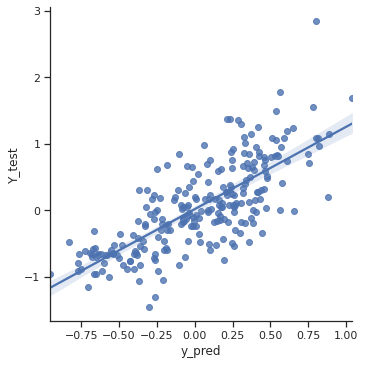

1
(999, 361)
(250, 361)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=42)
Calculating Permutation Importances
250
2-fold :  58.8
3-fold :  75.6
5-fold :  90.0
gmfe :  2.0704226320631536
mfe :  1.2587850926363089
bias :  0.07394584112129457
rmse  0.41049049575076313
r2  0.5486659689071742
saving model


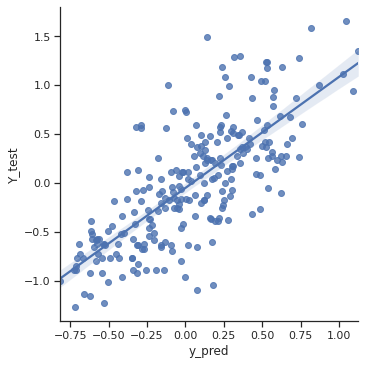

2
(999, 361)
(250, 361)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=42)
Calculating Permutation Importances
250
2-fold :  57.199999999999996
3-fold :  73.6
5-fold :  86.0
gmfe :  2.207487636005051
mfe :  1.2496652069177219
bias :  0.0001467141538961797
rmse  0.47424911046954543
r2  0.4822177875139517


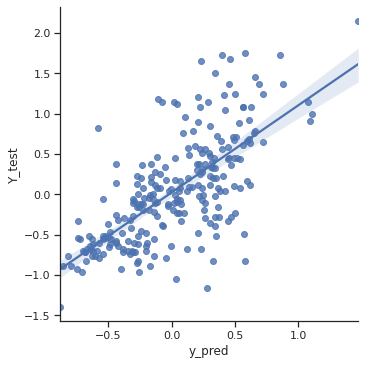

3
(999, 361)
(250, 361)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=42)
Calculating Permutation Importances
250
2-fold :  59.599999999999994
3-fold :  75.6
5-fold :  89.2
gmfe :  2.0881002353820852
mfe :  1.2707739970530438
bias :  0.006379804444018894
rmse  0.42521773303368765
r2  0.5682674062766224


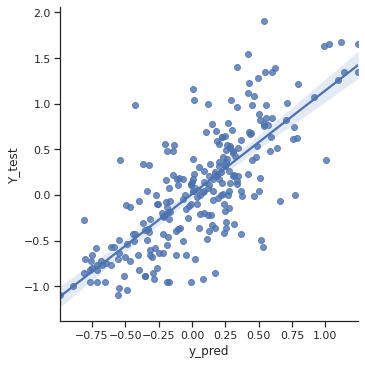

4
(1000, 361)
(249, 361)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
Calculating Permutation Importances
249
2-fold :  54.61847389558233
3-fold :  75.1004016064257
5-fold :  89.95983935742971
gmfe :  2.1875815930775797
mfe :  1.314289849268272
bias :  0.07520243523254877
rmse  0.44641163796371575
r2  0.48348709299811155


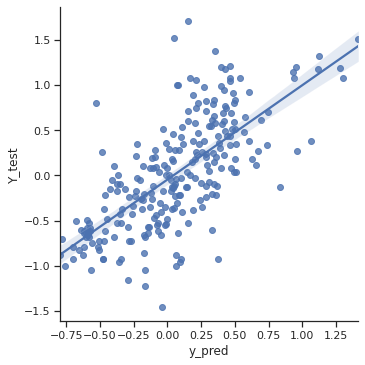

0
(999, 361)
(250, 361)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=43)
Calculating Permutation Importances
250
2-fold :  58.4
3-fold :  74.0
5-fold :  88.8
gmfe :  2.1319398101632254
mfe :  1.2724523466002478
bias :  0.039799099101634455
rmse  0.4279147133455055
r2  0.498712259203556


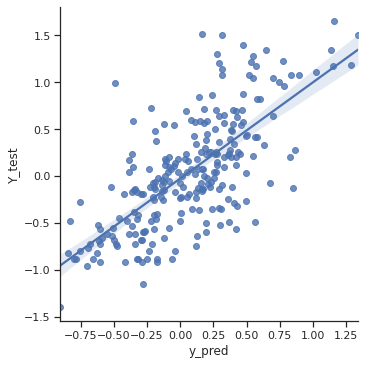

1
(999, 361)
(250, 361)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
Calculating Permutation Importances
250
2-fold :  54.0
3-fold :  70.8
5-fold :  86.4
gmfe :  2.283904069735312
mfe :  1.3051825109250106
bias :  0.03024072552861297
rmse  0.4719650344757214
r2  0.5156432870299181


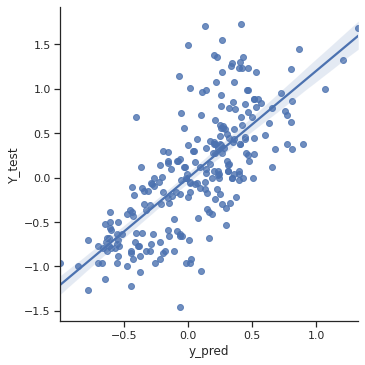

2
(999, 361)
(250, 361)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=43)
Calculating Permutation Importances
250
2-fold :  60.0
3-fold :  77.2
5-fold :  89.60000000000001
gmfe :  2.0853654276107583
mfe :  1.2549209278390872
bias :  0.03253195864323161
rmse  0.43269912923449716
r2  0.5232771622964765


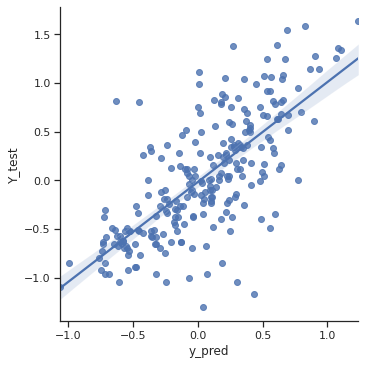

3
(999, 361)
(250, 361)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=43)
Calculating Permutation Importances
250
2-fold :  59.599999999999994
3-fold :  76.0
5-fold :  92.0
gmfe :  2.042312296381149
mfe :  1.2376854917440463
bias :  0.02849091762408512
rmse  0.4277919138183541
r2  0.5488642671715104
saving model


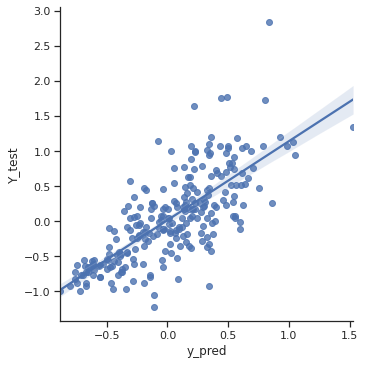

4
(1000, 361)
(249, 361)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=43)
Calculating Permutation Importances
249
2-fold :  55.42168674698795
3-fold :  74.69879518072288
5-fold :  90.36144578313254
gmfe :  2.115244151218727
mfe :  1.2952662171648008
bias :  0.027000030826178745
rmse  0.43461154795542717
r2  0.5511329196235927


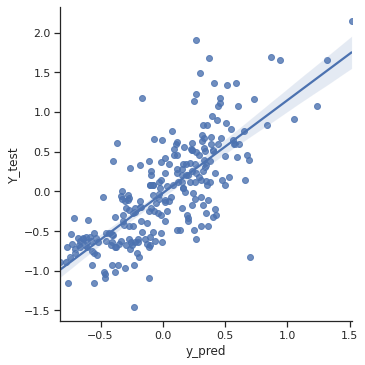

0
(999, 361)
(250, 361)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
Calculating Permutation Importances
250
2-fold :  54.800000000000004
3-fold :  75.2
5-fold :  86.4
gmfe :  2.191633557951569
mfe :  1.3037071997244511
bias :  0.0065138585057464005
rmse  0.4629375728421278
r2  0.4763766538409179


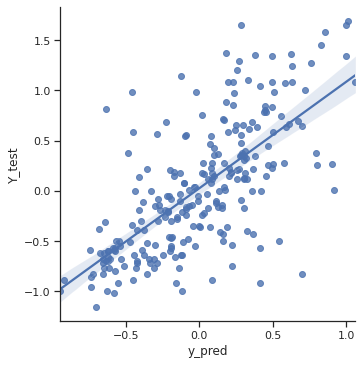

1
(999, 361)
(250, 361)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=44)
Calculating Permutation Importances
250
2-fold :  57.599999999999994
3-fold :  76.4
5-fold :  88.4
gmfe :  2.1883129585875576
mfe :  1.2908707338879577
bias :  0.04012994932645193
rmse  0.4492591824112794
r2  0.554599925300367


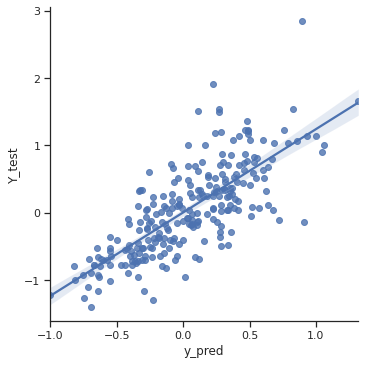

2
(999, 361)
(250, 361)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=44)
Calculating Permutation Importances
250
2-fold :  55.60000000000001
3-fold :  68.8
5-fold :  88.0
gmfe :  2.191774703858228
mfe :  1.300815750719193
bias :  0.06250437626214567
rmse  0.44524637447228943
r2  0.5255357556009951


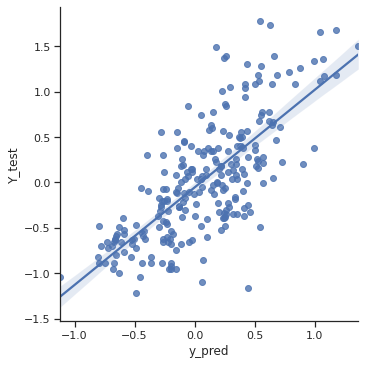

3
(999, 361)
(250, 361)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=44)
Calculating Permutation Importances
250
2-fold :  61.6
3-fold :  76.0
5-fold :  92.0
gmfe :  2.0442719374794756
mfe :  1.262193268020516
bias :  0.047554983681453805
rmse  0.41339955427682196
r2  0.530811041037996


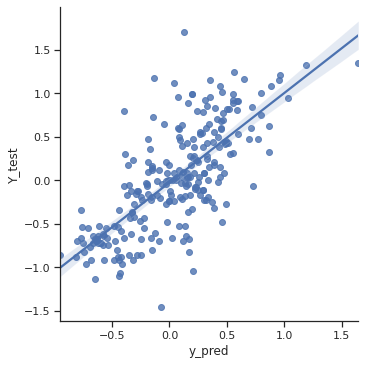

4
(1000, 361)
(249, 361)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=44)
Calculating Permutation Importances
249
2-fold :  61.044176706827315
3-fold :  79.91967871485943
5-fold :  90.36144578313254
gmfe :  2.027614523667056
mfe :  1.2545573232624825
bias :  0.010849868297856946
rmse  0.4131870794427807
r2  0.574870929738055
saving model


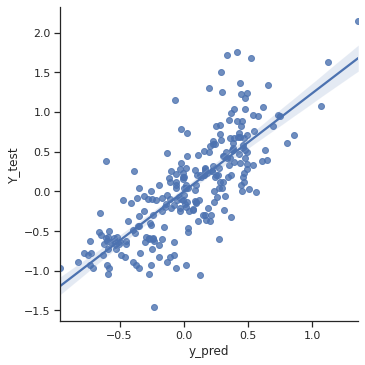

0
(999, 361)
(250, 361)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
250
2-fold :  57.599999999999994
3-fold :  74.8
5-fold :  88.0
gmfe :  2.1732921444567084
mfe :  1.2887263578832537
bias :  -0.005319687202691645
rmse  0.4650495466609075
r2  0.4774114600858571


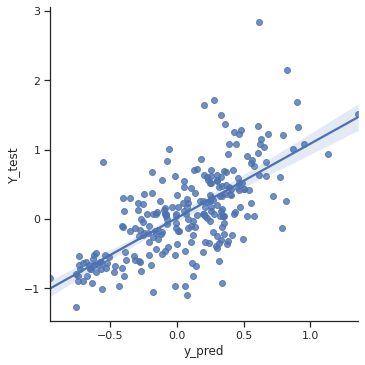

1
(999, 361)
(250, 361)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=45)
Calculating Permutation Importances
250
2-fold :  56.8
3-fold :  77.60000000000001
5-fold :  88.8
gmfe :  2.0689259322682325
mfe :  1.2669339740180565
bias :  0.016939285292672468
rmse  0.4225702596075004
r2  0.49397958997228264


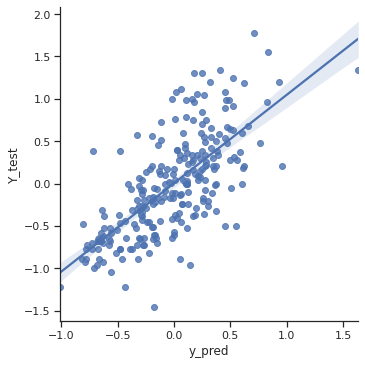

2
(999, 361)
(250, 361)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=45)
Calculating Permutation Importances
250
2-fold :  57.599999999999994
3-fold :  73.6
5-fold :  86.8
gmfe :  2.2528336847434036
mfe :  1.27795106390914
bias :  0.003942783891317692
rmse  0.47409102951177334
r2  0.5078253181244465


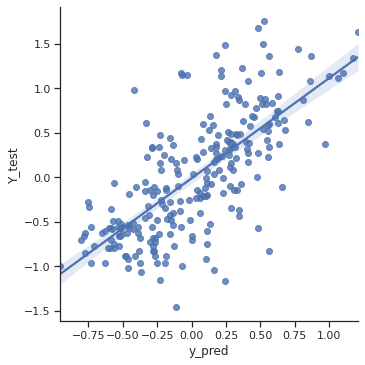

3
(999, 361)
(250, 361)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
250
2-fold :  54.800000000000004
3-fold :  76.0
5-fold :  88.4
gmfe :  2.151720307012419
mfe :  1.3217886556086837
bias :  0.13003770008439475
rmse  0.4261572712807451
r2  0.5391789167843802


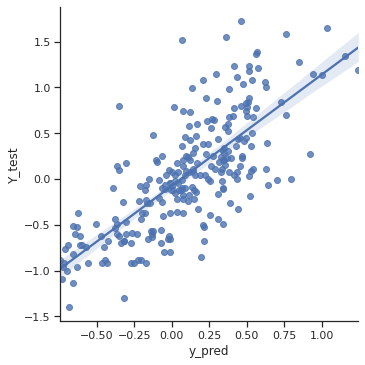

4
(1000, 361)
(249, 361)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
249
2-fold :  60.6425702811245
3-fold :  76.30522088353415
5-fold :  91.96787148594377
gmfe :  2.0405198422579627
mfe :  1.273087895654014
bias :  0.023595601231428343
rmse  0.40277403254642496
r2  0.6168654149676914


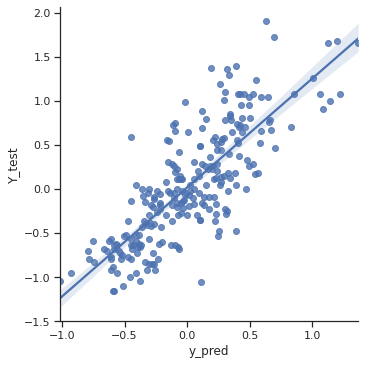

0
(999, 361)
(250, 361)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_jobs=30, random_state=46)
Calculating Permutation Importances
250
2-fold :  55.60000000000001
3-fold :  77.2
5-fold :  87.6
gmfe :  2.1221697246144724
mfe :  1.265007742270413
bias :  0.020173053344063538
rmse  0.43372310824982563
r2  0.5180605479043519


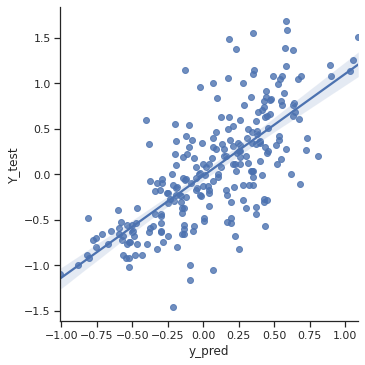

1
(999, 361)
(250, 361)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=46)
Calculating Permutation Importances
250
2-fold :  60.0
3-fold :  75.6
5-fold :  91.2
gmfe :  2.121470378781872
mfe :  1.274990064735645
bias :  0.08456977880384217
rmse  0.43666964225217797
r2  0.5497405452219902


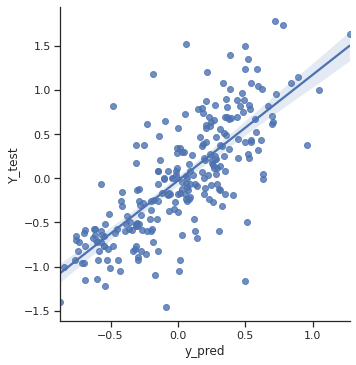

2
(999, 361)
(250, 361)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=46)
Calculating Permutation Importances
250
2-fold :  58.8
3-fold :  76.4
5-fold :  89.2
gmfe :  2.0731789694457503
mfe :  1.2656416571713318
bias :  0.009879816366102204
rmse  0.4273765506140223
r2  0.5497294361254448


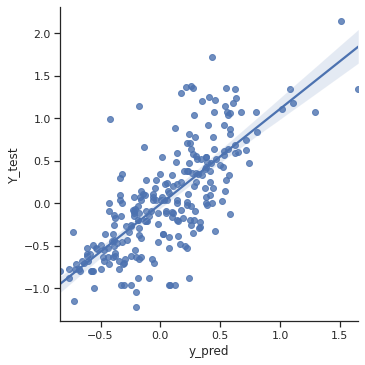

3
(999, 361)
(250, 361)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=46)
Calculating Permutation Importances
250
2-fold :  53.6
3-fold :  74.0
5-fold :  90.8
gmfe :  2.1587182767405837
mfe :  1.313513171300982
bias :  -0.012737658304974489
rmse  0.4293368953109051
r2  0.5654101857669547


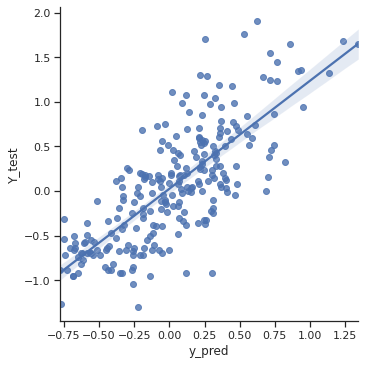

4
(1000, 361)
(249, 361)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=46)
Calculating Permutation Importances
249
2-fold :  55.42168674698795
3-fold :  75.50200803212851
5-fold :  89.5582329317269
gmfe :  2.154532378247459
mfe :  1.291935282486649
bias :  0.04931300311482517
rmse  0.4484775146145135
r2  0.4983238767804621


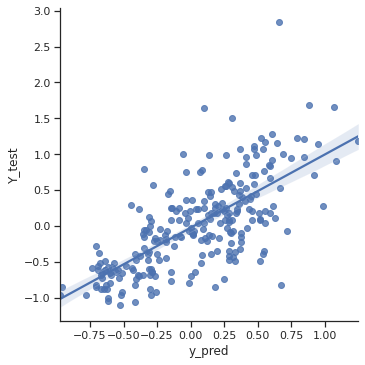

human_CL_mL_min_kg
0
(1024, 361)
(257, 361)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=42)
Calculating Permutation Importances
257
2-fold :  47.081712062256805
3-fold :  73.15175097276264
5-fold :  83.65758754863813
gmfe :  2.543222600588626
mfe :  1.3660870708556985
bias :  -0.1912652311905103
rmse  0.5673095986734231
r2  0.29429942419127786
saving model


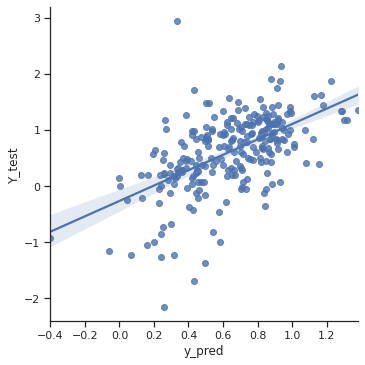

1
(1025, 361)
(256, 361)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
Calculating Permutation Importances
256
2-fold :  50.390625
3-fold :  72.265625
5-fold :  84.375
gmfe :  2.401543159219184
mfe :  1.3456730199723803
bias :  -0.4317073073283522
rmse  0.5164741586898193
r2  0.343383097893322
saving model


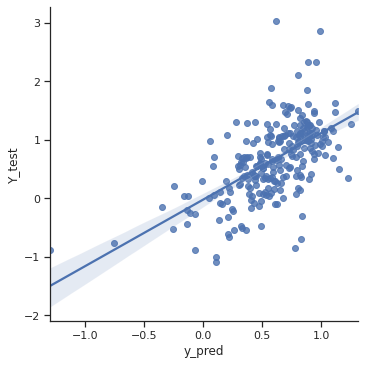

2
(1025, 361)
(256, 361)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=42)
Calculating Permutation Importances
256
2-fold :  53.90625
3-fold :  71.484375
5-fold :  83.59375
gmfe :  2.4469156374760717
mfe :  1.315636304664479
bias :  -0.4034719284160242
rmse  0.525224515883451
r2  0.23572181260895508


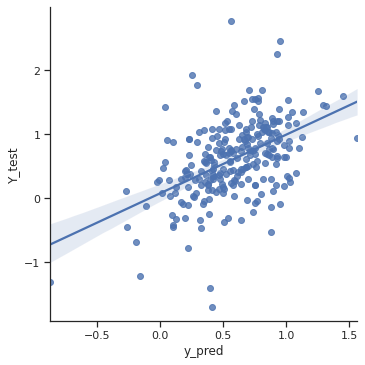

3
(1025, 361)
(256, 361)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=200, n_jobs=30,
                      random_state=42)
Calculating Permutation Importances
256
2-fold :  49.21875
3-fold :  70.703125
5-fold :  86.328125
gmfe :  2.445431611008422
mfe :  1.3614236986858672
bias :  -0.43997972345839154
rmse  0.5287215728948866
r2  0.35387482547487414


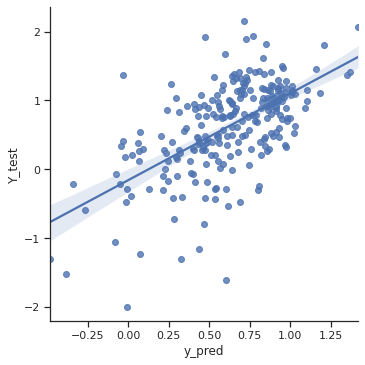

4
(1025, 361)
(256, 361)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_jobs=30, random_state=42)
Calculating Permutation Importances
256
2-fold :  49.21875
3-fold :  66.796875
5-fold :  82.421875
gmfe :  2.6758195402107443
mfe :  1.3594638745352363
bias :  0.14593570162484626
rmse  0.6009522425361051
r2  0.19321511980411965


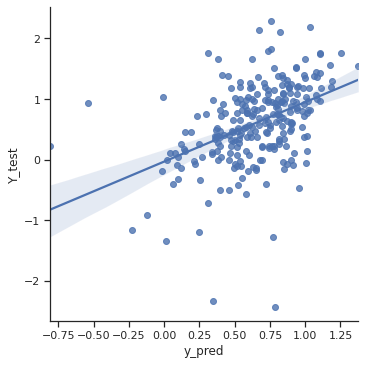

0
(1024, 361)
(257, 361)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=43)
Calculating Permutation Importances
257
2-fold :  51.75097276264592
3-fold :  66.14785992217898
5-fold :  82.10116731517509
gmfe :  2.6696620554168415
mfe :  1.3223984525447574
bias :  -0.004827602914744711
rmse  0.6099209446144429
r2  0.2661965751504842


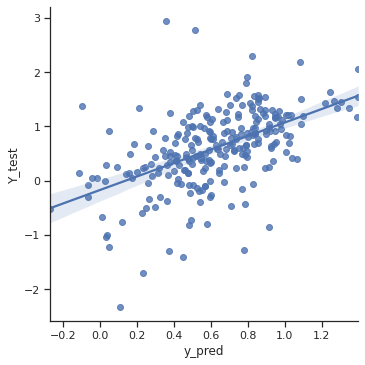

1
(1025, 361)
(256, 361)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=43)
Calculating Permutation Importances
256
2-fold :  43.75
3-fold :  66.40625
5-fold :  82.421875
gmfe :  2.803899082803259
mfe :  1.398427935224293
bias :  -0.21998434651320098
rmse  0.6026409714787929
r2  0.2743083737503168


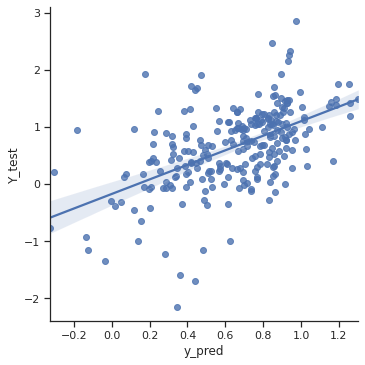

2
(1025, 361)
(256, 361)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=43)
Calculating Permutation Importances
256
2-fold :  47.265625
3-fold :  69.53125
5-fold :  84.765625
gmfe :  2.4136275419256403
mfe :  1.3744242454089204
bias :  -0.3242896629009262
rmse  0.498285458552072
r2  0.31289337263442274


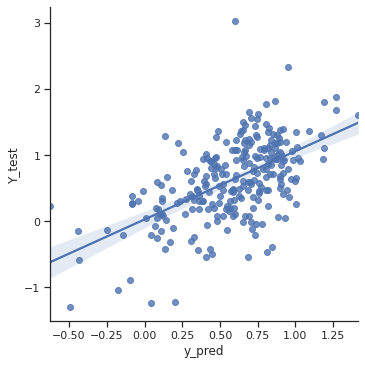

3
(1025, 361)
(256, 361)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=43)
Calculating Permutation Importances
256
2-fold :  52.734375
3-fold :  73.828125
5-fold :  85.9375
gmfe :  2.334395797516388
mfe :  1.3210058946340366
bias :  -0.26753600696734225
rmse  0.4994688594607648
r2  0.3152898350641614
saving model


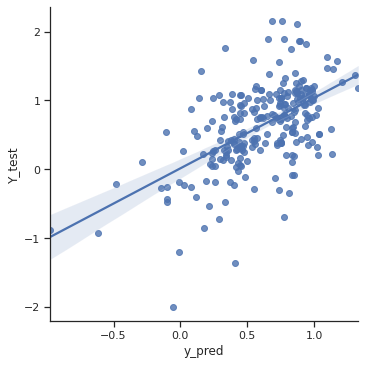

4
(1025, 361)
(256, 361)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=43)
Calculating Permutation Importances
256
2-fold :  55.46875
3-fold :  71.484375
5-fold :  85.15625
gmfe :  2.3003284798788983
mfe :  1.299023189719908
bias :  -0.31916615644749513
rmse  0.5008025018454366
r2  0.32210266953534616
saving model


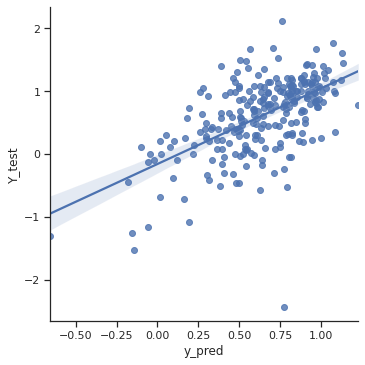

0
(1024, 361)
(257, 361)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
Calculating Permutation Importances
257
2-fold :  52.14007782101168
3-fold :  73.15175097276264
5-fold :  86.7704280155642
gmfe :  2.365386536867604
mfe :  1.3354669103900616
bias :  -0.18969455457895812
rmse  0.506030418863717
r2  0.366563780429361


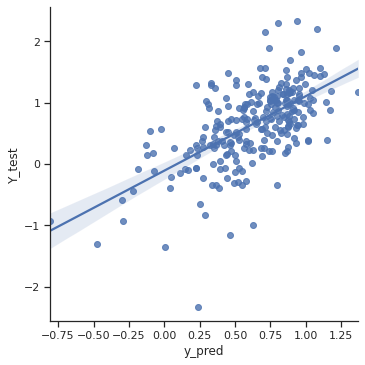

1
(1025, 361)
(256, 361)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=44)
Calculating Permutation Importances
256
2-fold :  53.90625
3-fold :  71.875
5-fold :  86.71875
gmfe :  2.3669801979747134
mfe :  1.3048407481514201
bias :  -0.481487366384175
rmse  0.5243929482029738
r2  0.3027148197583893


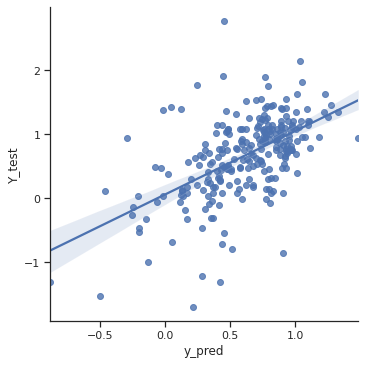

2
(1025, 361)
(256, 361)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=44)
Calculating Permutation Importances
256
2-fold :  51.953125
3-fold :  70.3125
5-fold :  83.203125
gmfe :  2.527402227708501
mfe :  1.336221837274988
bias :  0.14318902055015875
rmse  0.558178018164626
r2  0.31117300691317096


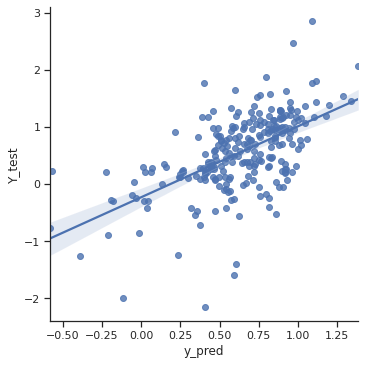

3
(1025, 361)
(256, 361)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=44)
Calculating Permutation Importances
256
2-fold :  48.046875
3-fold :  67.1875
5-fold :  83.984375
gmfe :  2.6559769060608174
mfe :  1.3599113799384472
bias :  -0.07793019742534117
rmse  0.5921137078700861
r2  0.23410816365514375


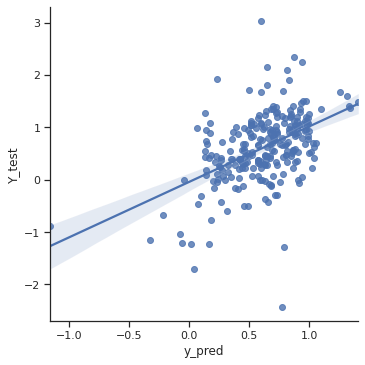

4
(1025, 361)
(256, 361)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
Calculating Permutation Importances
256
2-fold :  48.828125
3-fold :  69.140625
5-fold :  84.375
gmfe :  2.4297063369154634
mfe :  1.360794661229498
bias :  -0.44101715987134305
rmse  0.518092588404411
r2  0.308377297352909


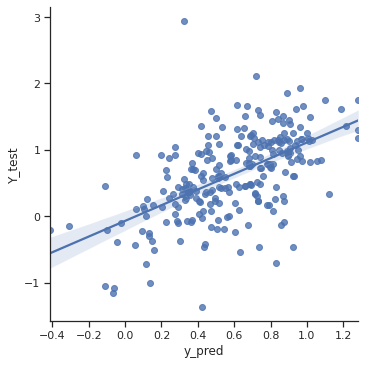

0
(1024, 361)
(257, 361)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=45)
Calculating Permutation Importances
257
2-fold :  45.525291828793776
3-fold :  73.54085603112841
5-fold :  89.49416342412452
gmfe :  2.3259965700940075
mfe :  1.3841906467806304
bias :  -0.37250165279509906
rmse  0.4620936521177402
r2  0.3589146661625382


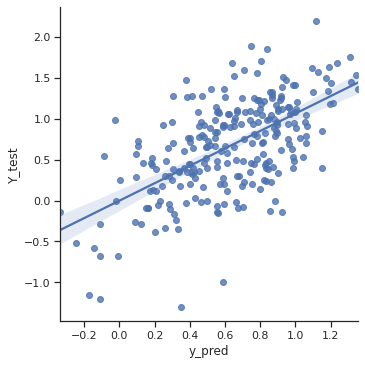

1
(1025, 361)
(256, 361)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=45)
Calculating Permutation Importances
256
2-fold :  52.734375
3-fold :  69.140625
5-fold :  82.8125
gmfe :  2.459335355189723
mfe :  1.3363381525268117
bias :  0.3164266161167758
rmse  0.5098423130236721
r2  0.30319828457601805


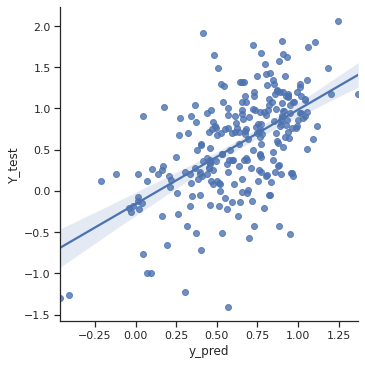

2
(1025, 361)
(256, 361)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
256
2-fold :  49.609375
3-fold :  70.703125
5-fold :  82.8125
gmfe :  2.5750275497997417
mfe :  1.3526776506349067
bias :  -0.6683455997999067
rmse  0.58646495012241
r2  0.2265290410758769


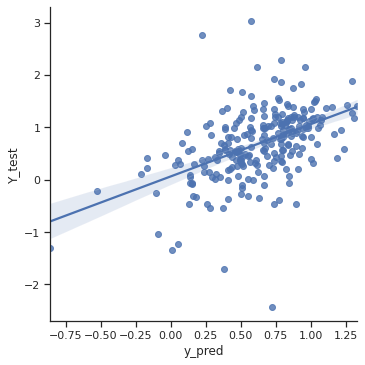

3
(1025, 361)
(256, 361)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
256
2-fold :  53.125
3-fold :  69.53125
5-fold :  84.765625
gmfe :  2.4696421248643547
mfe :  1.3085571287154323
bias :  -0.19037562501035482
rmse  0.5508665647046885
r2  0.25936613753531235


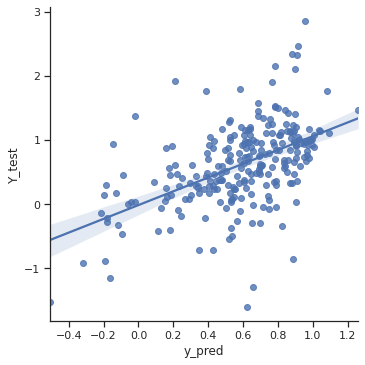

4
(1025, 361)
(256, 361)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
256
2-fold :  50.0
3-fold :  67.578125
5-fold :  83.203125
gmfe :  2.657133018332944
mfe :  1.3525709975130784
bias :  -0.13277997639178507
rmse  0.6087792457374118
r2  0.30405029293495756


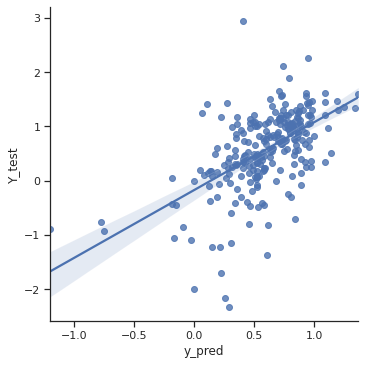

0
(1024, 361)
(257, 361)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=200, n_jobs=30,
                      random_state=46)
Calculating Permutation Importances
257
2-fold :  54.08560311284047
3-fold :  67.70428015564202
5-fold :  85.60311284046692
gmfe :  2.455123542676801
mfe :  1.3216202253913667
bias :  -0.7075438907904692
rmse  0.5501950736011637
r2  0.24829814098174974


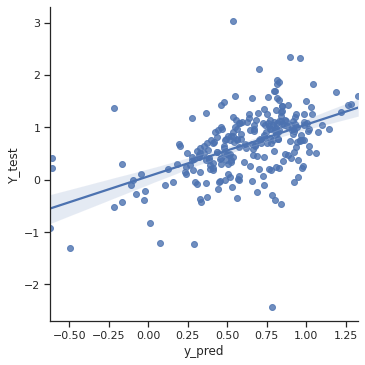

1
(1025, 361)
(256, 361)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=46)
Calculating Permutation Importances
256
2-fold :  49.21875
3-fold :  64.0625
5-fold :  80.859375
gmfe :  2.746952305944815
mfe :  1.359979706606694
bias :  0.06114973956542584
rmse  0.5990838168365111
r2  0.3002645441189167


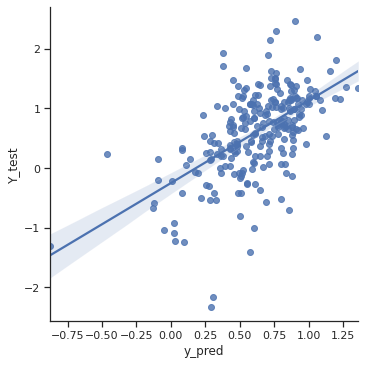

2
(1025, 361)
(256, 361)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=46)
Calculating Permutation Importances
256
2-fold :  53.90625
3-fold :  71.09375
5-fold :  82.8125
gmfe :  2.475448125062328
mfe :  1.3187056237399915
bias :  0.2572854643466227
rmse  0.5592101160810807
r2  0.2882473733444961


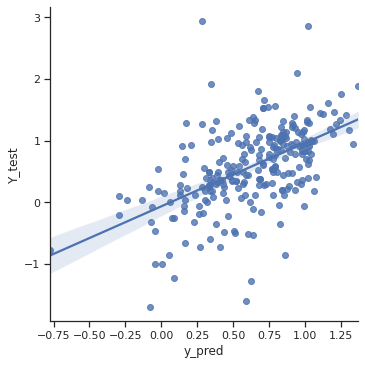

3
(1025, 361)
(256, 361)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=46)
Calculating Permutation Importances
256
2-fold :  47.65625
3-fold :  69.53125
5-fold :  85.546875
gmfe :  2.4733985508028002
mfe :  1.3724054661807992
bias :  -0.05677642493801661
rmse  0.5290090536112645
r2  0.32931991914598924


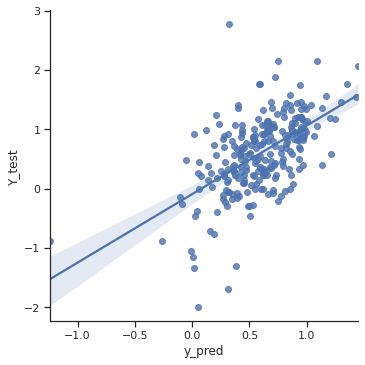

4
(1025, 361)
(256, 361)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=46)
Calculating Permutation Importances
256
2-fold :  54.296875
3-fold :  76.171875
5-fold :  88.28125
gmfe :  2.2396397254888143
mfe :  1.3217151565300027
bias :  -0.3384263818662574
rmse  0.4582409202708438
r2  0.35945506211196543
saving model


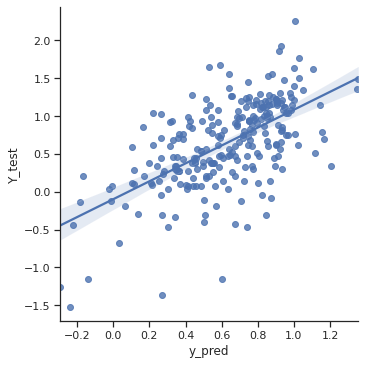

human_fup
0
(703, 361)
(176, 361)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=200, n_jobs=30,
                      random_state=42)
Calculating Permutation Importances
176
2-fold :  51.13636363636363
3-fold :  64.20454545454545
5-fold :  73.86363636363636
gmfe :  3.081994806968173
mfe :  1.3266836709903251
bias :  0.048278267881937696
rmse  0.20716968914032532
r2  0.6521708925038276
saving model


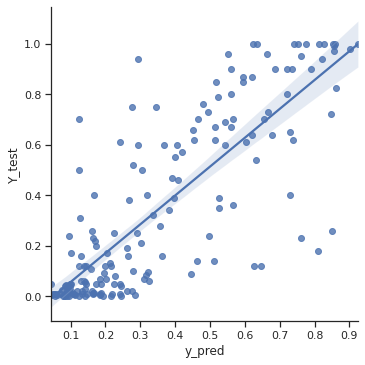

1
(703, 361)
(176, 361)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=42)
Calculating Permutation Importances
176
2-fold :  55.68181818181818
3-fold :  70.45454545454545
5-fold :  80.11363636363636
gmfe :  2.700268190287841
mfe :  1.2718389262026484
bias :  0.046372946532076936
rmse  0.1966557232773371
r2  0.6183231716723425
saving model


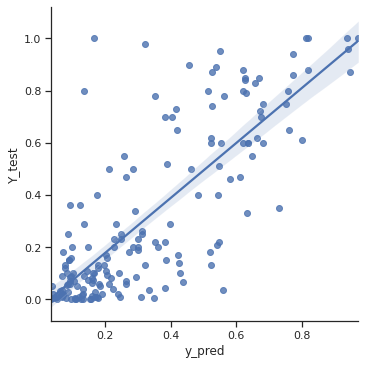

2
(703, 361)
(176, 361)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=42)
Calculating Permutation Importances
176
2-fold :  58.52272727272727
3-fold :  71.02272727272727
5-fold :  84.0909090909091
gmfe :  2.4997063039389906
mfe :  1.266114567127022
bias :  -0.00311031748510833
rmse  0.22780083820476404
r2  0.5680953103538398
saving model


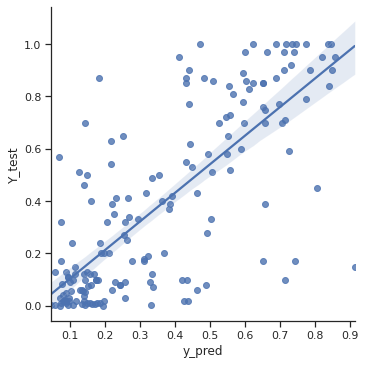

3
(703, 361)
(176, 361)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=8, n_jobs=30, random_state=42)
Calculating Permutation Importances
176
2-fold :  53.97727272727273
3-fold :  67.04545454545455
5-fold :  77.8409090909091
gmfe :  2.728420349598766
mfe :  1.2960763302462492
bias :  0.045844938507262845
rmse  0.21292561231618592
r2  0.6219571989319166


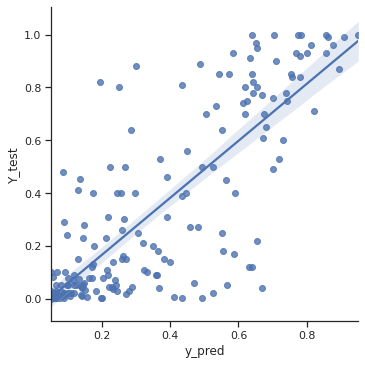

4
(704, 361)
(175, 361)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=42)
Calculating Permutation Importances
175
2-fold :  54.285714285714285
3-fold :  68.57142857142857
5-fold :  75.42857142857143
gmfe :  2.706255582369825
mfe :  1.2697514953576576
bias :  0.04301919816468591
rmse  0.20149992582137558
r2  0.6401131122134462


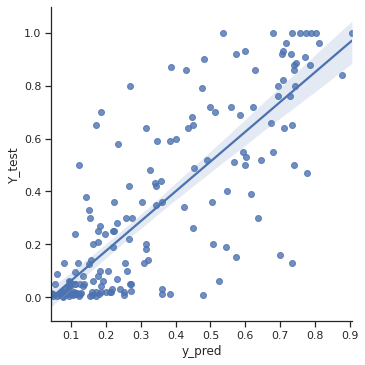

0
(703, 361)
(176, 361)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=43)
Calculating Permutation Importances
176
2-fold :  53.97727272727273
3-fold :  67.61363636363636
5-fold :  80.11363636363636
gmfe :  2.664759138500578
mfe :  1.3031426613089263
bias :  0.042176669157856235
rmse  0.2198817926121071
r2  0.5788351120516357


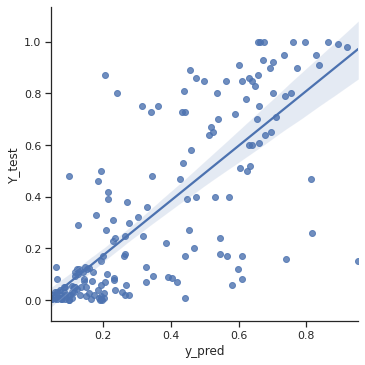

1
(703, 361)
(176, 361)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=43)
Calculating Permutation Importances
176
2-fold :  57.38636363636363
3-fold :  67.04545454545455
5-fold :  78.4090909090909
gmfe :  2.6946824729258276
mfe :  1.246415303741892
bias :  0.044003564703204476
rmse  0.19187826540312392
r2  0.643177889171376


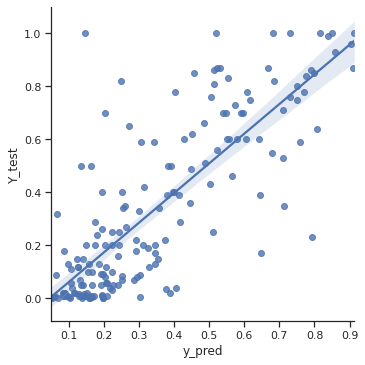

2
(703, 361)
(176, 361)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=43)
Calculating Permutation Importances
176
2-fold :  54.54545454545454
3-fold :  67.04545454545455
5-fold :  75.0
gmfe :  3.0684352135245794
mfe :  1.2614490800842002
bias :  0.05050232919909839
rmse  0.21833637010404602
r2  0.6504348209020892


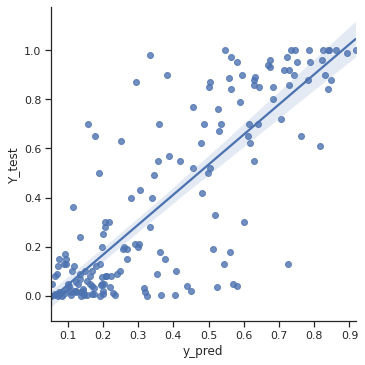

3
(703, 361)
(176, 361)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=200, n_jobs=30,
                      random_state=43)
Calculating Permutation Importances
176
2-fold :  54.54545454545454
3-fold :  69.31818181818183
5-fold :  78.4090909090909
gmfe :  2.920878613420488
mfe :  1.3104784823364757
bias :  0.03257550848918478
rmse  0.23519883348508622
r2  0.5639035464388495


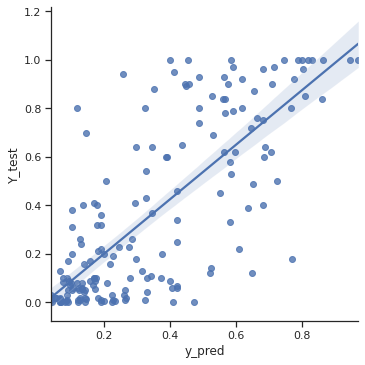

4
(704, 361)
(175, 361)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=43)
Calculating Permutation Importances
175
2-fold :  56.57142857142857
3-fold :  70.85714285714285
5-fold :  82.85714285714286
gmfe :  2.4099850585419706
mfe :  1.2641233894615285
bias :  0.0397819216288928
rmse  0.18242884750522737
r2  0.6600387571004334
saving model


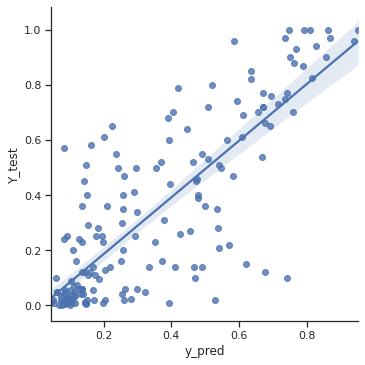

0
(703, 361)
(176, 361)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=8, n_jobs=30, random_state=44)
Calculating Permutation Importances
176
2-fold :  57.38636363636363
3-fold :  69.31818181818183
5-fold :  81.81818181818183
gmfe :  2.4672707608270183
mfe :  1.2590513933371685
bias :  0.041236659820702605
rmse  0.20245581991904957
r2  0.6638283345254348


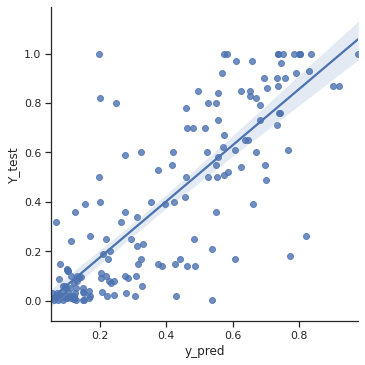

1
(703, 361)
(176, 361)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_jobs=30, random_state=44)
Calculating Permutation Importances
176
2-fold :  53.97727272727273
3-fold :  66.47727272727273
5-fold :  76.70454545454545
gmfe :  2.7506338349811954
mfe :  1.2872761410135027
bias :  0.03440819194001517
rmse  0.21409343545919718
r2  0.5805533621034022


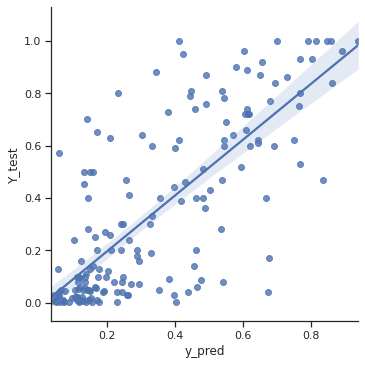

2
(703, 361)
(176, 361)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
Calculating Permutation Importances
176
2-fold :  55.11363636363637
3-fold :  67.04545454545455
5-fold :  77.27272727272727
gmfe :  2.943794100396529
mfe :  1.2514265598408838
bias :  0.04236088086920716
rmse  0.2081827719853936
r2  0.6228445595721939


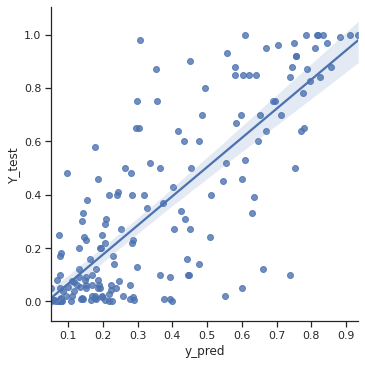

3
(703, 361)
(176, 361)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=200, n_jobs=30,
                      random_state=44)
Calculating Permutation Importances
176
2-fold :  56.81818181818182
3-fold :  68.75
5-fold :  79.54545454545455
gmfe :  2.800984367126433
mfe :  1.2706426925453955
bias :  0.03432756642584289
rmse  0.21237474403401763
r2  0.6364886033123852


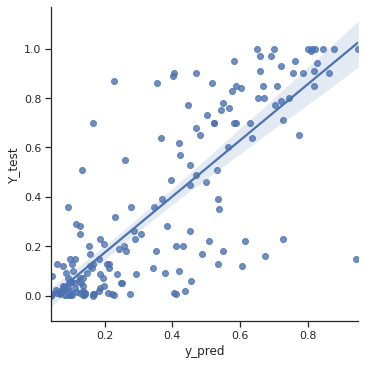

4
(704, 361)
(175, 361)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=44)
Calculating Permutation Importances
175
2-fold :  54.285714285714285
3-fold :  63.42857142857142
5-fold :  76.0
gmfe :  2.7022765918897593
mfe :  1.300710992750456
bias :  0.05146982074577902
rmse  0.2052782104973826
r2  0.6131554932740375


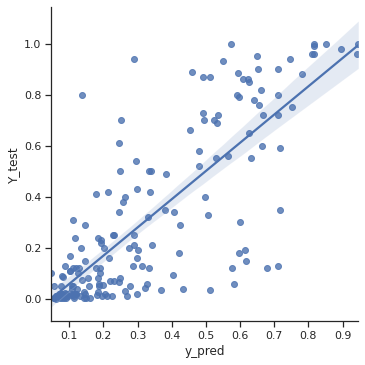

0
(703, 361)
(176, 361)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=45)
Calculating Permutation Importances
176
2-fold :  46.590909090909086
3-fold :  62.5
5-fold :  76.13636363636364
gmfe :  3.1562209127979393
mfe :  1.3999002195696844
bias :  0.05461962201465163
rmse  0.21521206500085452
r2  0.5049989754849454


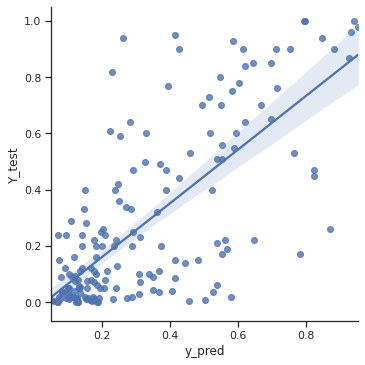

1
(703, 361)
(176, 361)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=45)
Calculating Permutation Importances
176
2-fold :  53.40909090909091
3-fold :  65.9090909090909
5-fold :  78.97727272727273
gmfe :  2.6313288525047347
mfe :  1.3155469882907438
bias :  0.028238100204382947
rmse  0.23539574096650406
r2  0.5211659995153913


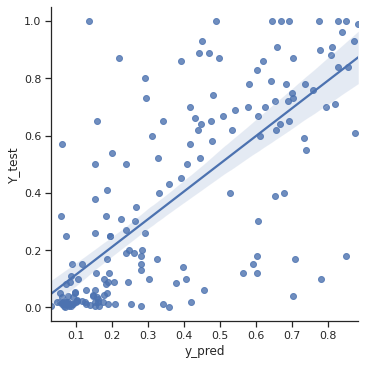

2
(703, 361)
(176, 361)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=8, n_estimators=200, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
176
2-fold :  56.81818181818182
3-fold :  69.31818181818183
5-fold :  79.54545454545455
gmfe :  2.674434837535664
mfe :  1.2506747129968303
bias :  0.02348945001168609
rmse  0.2069832662862172
r2  0.6612113556757102


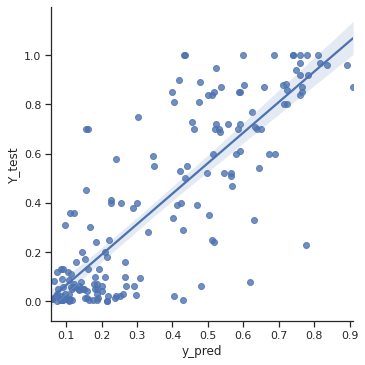

3
(703, 361)
(176, 361)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
176
2-fold :  59.09090909090909
3-fold :  69.88636363636364
5-fold :  78.97727272727273
gmfe :  2.616349984835462
mfe :  1.2429692442270588
bias :  0.03368380513544476
rmse  0.2007159968022835
r2  0.6457493245528547


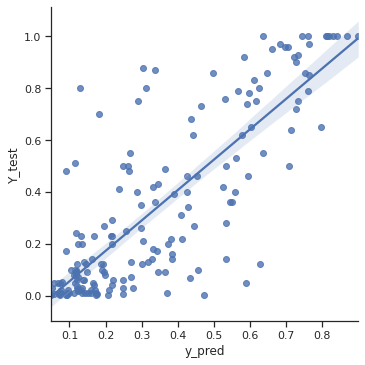

4
(704, 361)
(175, 361)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=200, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
175
2-fold :  59.42857142857143
3-fold :  72.0
5-fold :  78.85714285714286
gmfe :  2.6550161878966163
mfe :  1.2245639207641117
bias :  0.02861561706851497
rmse  0.1982354688910243
r2  0.6840908995693811


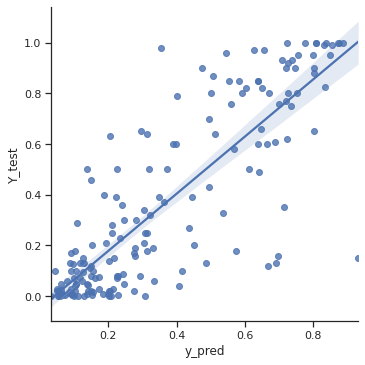

0
(703, 361)
(176, 361)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=46)
Calculating Permutation Importances
176
2-fold :  53.40909090909091
3-fold :  65.3409090909091
5-fold :  75.0
gmfe :  2.9744673990809676
mfe :  1.2910685598893081
bias :  0.04342877385698791
rmse  0.22442993676301057
r2  0.5882712663131546


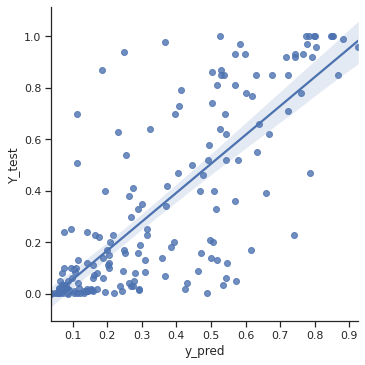

1
(703, 361)
(176, 361)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=46)
Calculating Permutation Importances
176
2-fold :  57.95454545454546
3-fold :  72.72727272727273
5-fold :  81.25
gmfe :  2.5784224252109915
mfe :  1.2443065378989744
bias :  0.015574288317969018
rmse  0.19899092426216894
r2  0.6406155197428514


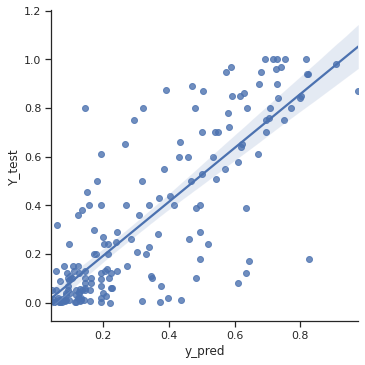

2
(703, 361)
(176, 361)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=46)
Calculating Permutation Importances
176
2-fold :  51.70454545454546
3-fold :  63.63636363636363
5-fold :  78.4090909090909
gmfe :  2.758981666837611
mfe :  1.3293906864023366
bias :  0.05720330551573568
rmse  0.21654111302257506
r2  0.6087148739936645


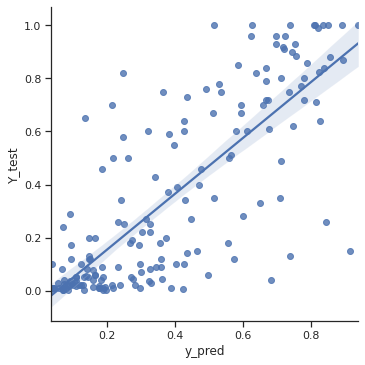

3
(703, 361)
(176, 361)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=46)
Calculating Permutation Importances
176
2-fold :  61.93181818181818
3-fold :  72.1590909090909
5-fold :  80.68181818181817
gmfe :  2.6075533540048417
mfe :  1.2062214009051362
bias :  0.03306876034935167
rmse  0.18385566288906066
r2  0.6869723784844297


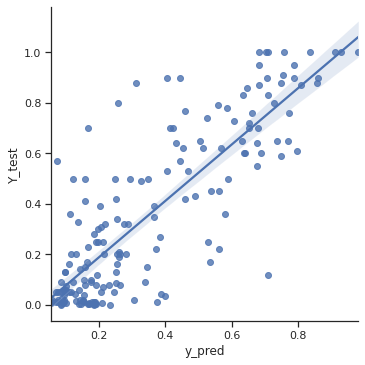

4
(704, 361)
(175, 361)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=8, n_estimators=200, n_jobs=30,
                      random_state=46)
Calculating Permutation Importances
175
2-fold :  52.0
3-fold :  66.28571428571428
5-fold :  76.57142857142857
gmfe :  2.7077253062916817
mfe :  1.323666071986666
bias :  0.03815601025864376
rmse  0.21095664871425557
r2  0.6296361264850129


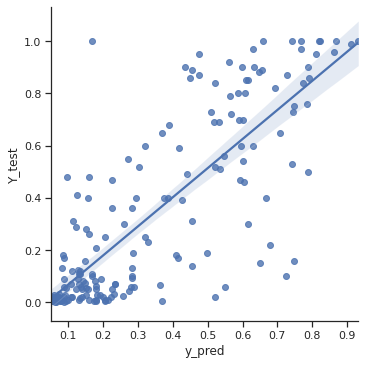

human_mrt
0
(994, 361)
(249, 361)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=42)
Calculating Permutation Importances
249
2-fold :  46.1847389558233
3-fold :  70.28112449799197
5-fold :  83.13253012048193
gmfe :  2.498621230917362
mfe :  1.367303667090061
bias :  0.02932632948638858
rmse  0.5304617571124166
r2  0.2686717875370369
saving model


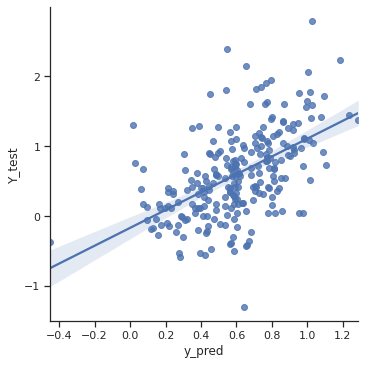

1
(994, 361)
(249, 361)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=200, n_jobs=30, random_state=42)
Calculating Permutation Importances
249
2-fold :  47.791164658634536
3-fold :  72.28915662650603
5-fold :  87.14859437751004
gmfe :  2.4540653694305834
mfe :  1.3668737292077973
bias :  -0.3355063900571005
rmse  0.5288259087237238
r2  0.22976318876304458
saving model


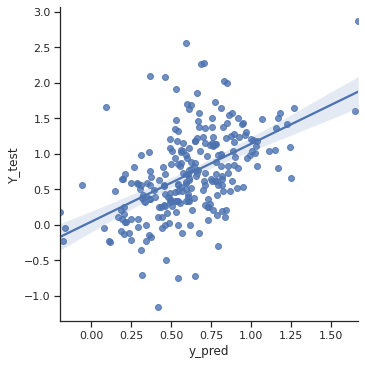

2
(994, 361)
(249, 361)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=42)
Calculating Permutation Importances
249
2-fold :  53.41365461847389
3-fold :  71.08433734939759
5-fold :  82.32931726907631
gmfe :  2.5666319846599186
mfe :  1.328602987572001
bias :  0.09988276297614718
rmse  0.5621002379015434
r2  0.27863157867582433


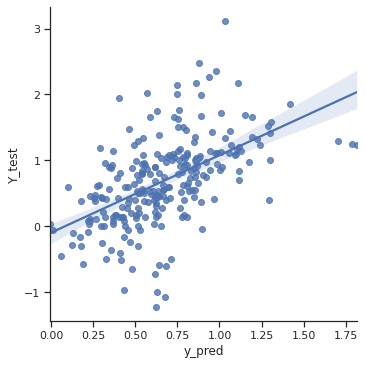

3
(995, 361)
(248, 361)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=42)
Calculating Permutation Importances
248
2-fold :  52.016129032258064
3-fold :  70.16129032258065
5-fold :  81.45161290322581
gmfe :  2.5666744577180918
mfe :  1.3380816288293353
bias :  -0.117039425443772
rmse  0.5889179367198736
r2  0.27708758390801136


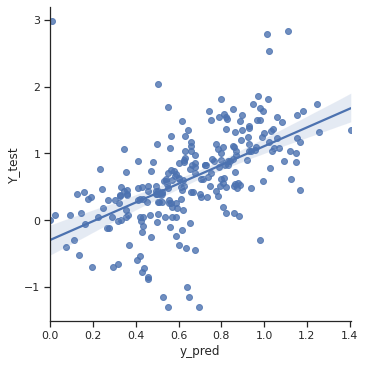

4
(995, 361)
(248, 361)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=42)
Calculating Permutation Importances
248
2-fold :  49.193548387096776
3-fold :  67.74193548387096
5-fold :  83.06451612903226
gmfe :  2.4759239812556304
mfe :  1.3631809715296985
bias :  0.5804458887496289
rmse  0.5299490292986866
r2  0.2610659779258352


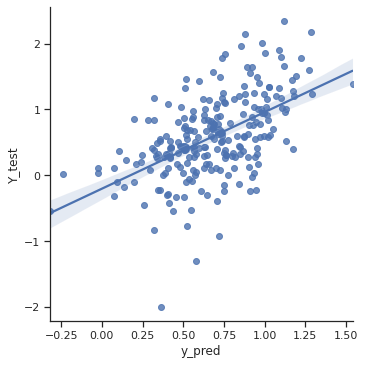

0
(994, 361)
(249, 361)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=43)
Calculating Permutation Importances
249
2-fold :  48.19277108433735
3-fold :  72.28915662650603
5-fold :  84.33734939759037
gmfe :  2.542135430719698
mfe :  1.3766569283036287
bias :  -0.22190727973370805
rmse  0.5522285784434323
r2  0.2595920615417142


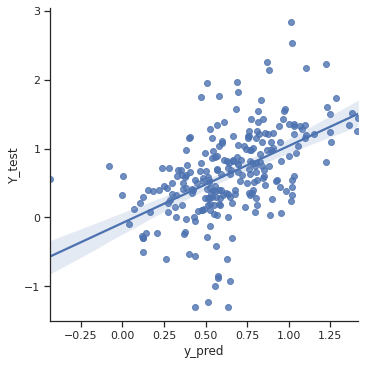

1
(994, 361)
(249, 361)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
Calculating Permutation Importances
249
2-fold :  44.97991967871486
3-fold :  67.06827309236948
5-fold :  79.51807228915662
gmfe :  2.7186469396194957
mfe :  1.3987268270052176
bias :  0.04109461186179697
rmse  0.5937642678480346
r2  0.26899067051931047


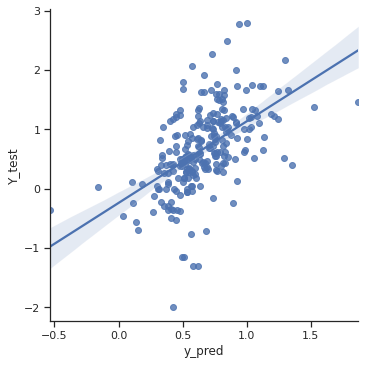

2
(994, 361)
(249, 361)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=43)
Calculating Permutation Importances
249
2-fold :  48.59437751004016
3-fold :  70.28112449799197
5-fold :  85.54216867469879
gmfe :  2.458092112272626
mfe :  1.3669789815865296
bias :  0.12726807682501073
rmse  0.5172292455019813
r2  0.28663466223447176


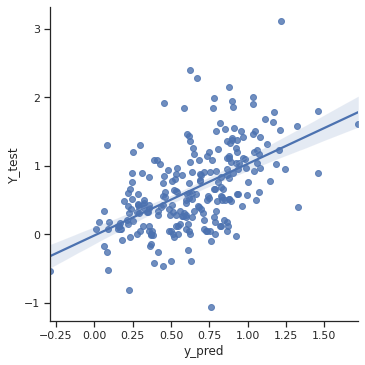

3
(995, 361)
(248, 361)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=43)
Calculating Permutation Importances
248
2-fold :  52.82258064516129
3-fold :  71.7741935483871
5-fold :  80.64516129032258
gmfe :  2.5648344446431777
mfe :  1.3125627274259803
bias :  -0.053573297689291866
rmse  0.5777203059972309
r2  0.2313602112016394


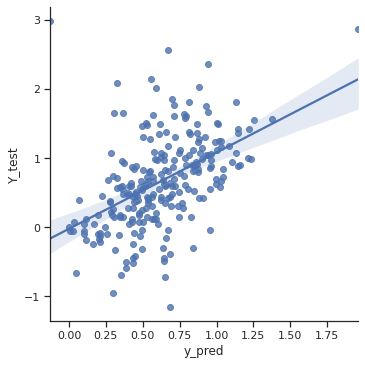

4
(995, 361)
(248, 361)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
Calculating Permutation Importances
248
2-fold :  55.64516129032258
3-fold :  73.79032258064517
5-fold :  86.69354838709677
gmfe :  2.2758682672736694
mfe :  1.304232676630392
bias :  0.441749991334343
rmse  0.48016455089341126
r2  0.3452850018829766
saving model


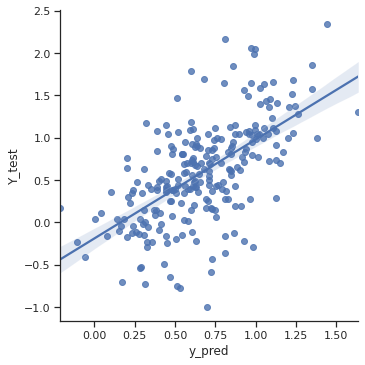

0
(994, 361)
(249, 361)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=44)
Calculating Permutation Importances
249
2-fold :  50.20080321285141
3-fold :  72.28915662650603
5-fold :  85.54216867469879
gmfe :  2.3529065782381133
mfe :  1.3456270971462019
bias :  -0.1725416070132697
rmse  0.500053315010894
r2  0.2895356910476502


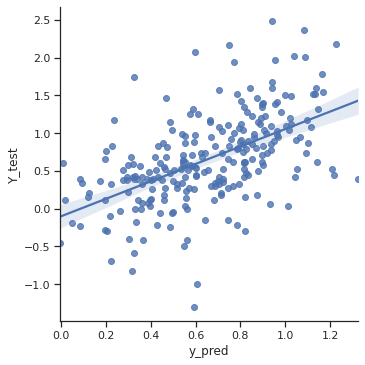

1
(994, 361)
(249, 361)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
Calculating Permutation Importances
249
2-fold :  55.020080321285135
3-fold :  70.28112449799197
5-fold :  83.13253012048193
gmfe :  2.599940791565469
mfe :  1.2946524902273264
bias :  0.36429099756665506
rmse  0.5974760737229733
r2  0.25520584882341657


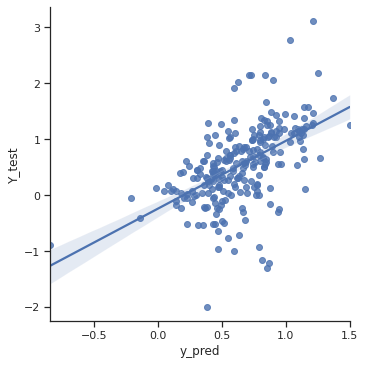

2
(994, 361)
(249, 361)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=44)
Calculating Permutation Importances
249
2-fold :  46.98795180722892
3-fold :  69.07630522088354
5-fold :  82.32931726907631
gmfe :  2.461451967494174
mfe :  1.3752290078539284
bias :  0.1712616301010621
rmse  0.522682683338957
r2  0.2947668832286289


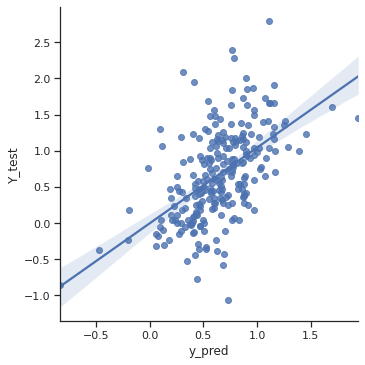

3
(995, 361)
(248, 361)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
Calculating Permutation Importances
248
2-fold :  51.61290322580645
3-fold :  70.96774193548387
5-fold :  82.25806451612904
gmfe :  2.5268153244197276
mfe :  1.313849649648174
bias :  0.29630753854501857
rmse  0.543420226350144
r2  0.24588650441325033


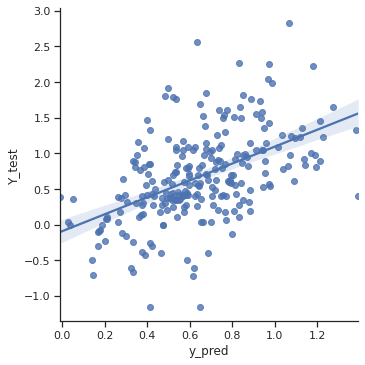

4
(995, 361)
(248, 361)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=200, n_jobs=30,
                      random_state=44)
Calculating Permutation Importances
248
2-fold :  49.193548387096776
3-fold :  69.75806451612904
5-fold :  83.87096774193549
gmfe :  2.4859090083199105
mfe :  1.3582943308702606
bias :  -0.26452529848614903
rmse  0.5450450965031057
r2  0.31689880534370474


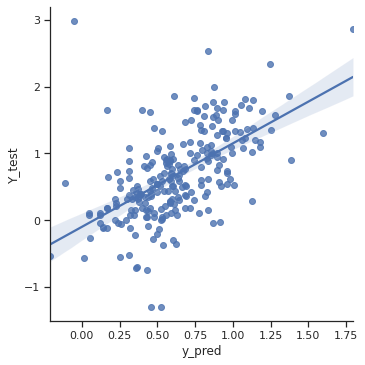

0
(994, 361)
(249, 361)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
249
2-fold :  48.99598393574297
3-fold :  69.47791164658635
5-fold :  83.53413654618474
gmfe :  2.548092081990212
mfe :  1.363340398524196
bias :  -0.506630679390248
rmse  0.5622537111217341
r2  0.21278598820303385


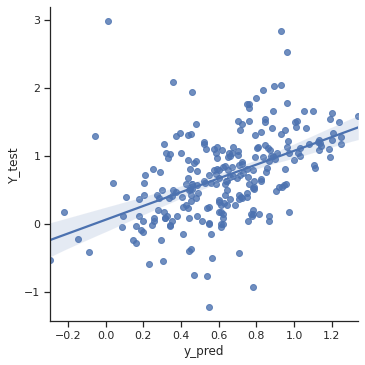

1
(994, 361)
(249, 361)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
249
2-fold :  48.19277108433735
3-fold :  67.8714859437751
5-fold :  80.72289156626506
gmfe :  2.740717276276993
mfe :  1.3675571721168522
bias :  0.2732408775482731
rmse  0.602213802106483
r2  0.25760629181196226


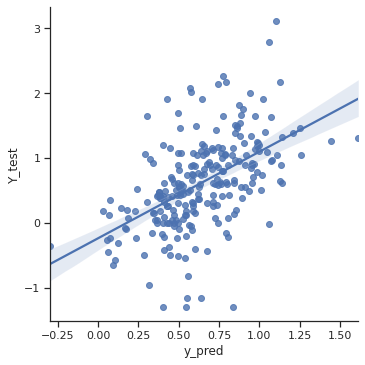

2
(994, 361)
(249, 361)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=45)
Calculating Permutation Importances
249
2-fold :  51.80722891566265
3-fold :  74.29718875502009
5-fold :  84.33734939759037
gmfe :  2.4184821363685836
mfe :  1.3390705863946957
bias :  -0.21249347468231905
rmse  0.5260235472819635
r2  0.3134836432353565


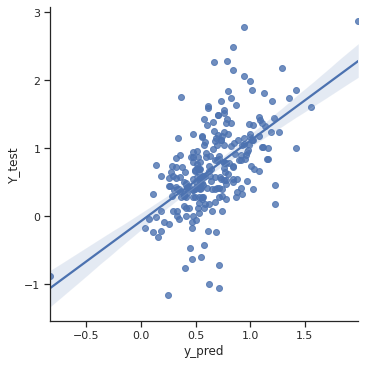

3
(995, 361)
(248, 361)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=300, n_jobs=30, random_state=45)
Calculating Permutation Importances
248
2-fold :  49.193548387096776
3-fold :  71.7741935483871
5-fold :  83.87096774193549
gmfe :  2.389963167172077
mfe :  1.3565172555092044
bias :  0.05191985090777518
rmse  0.4988588467838154
r2  0.31508120019766006


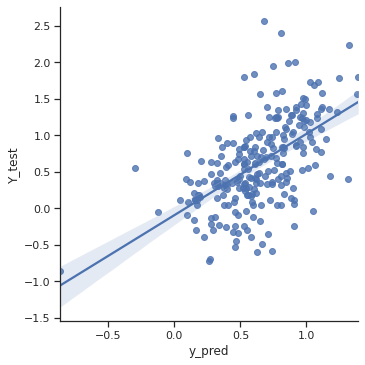

4
(995, 361)
(248, 361)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
248
2-fold :  52.41935483870967
3-fold :  69.75806451612904
5-fold :  83.87096774193549
gmfe :  2.4745097953178474
mfe :  1.3365355892737674
bias :  0.6339668651197521
rmse  0.5314199243719809
r2  0.27543053620138147


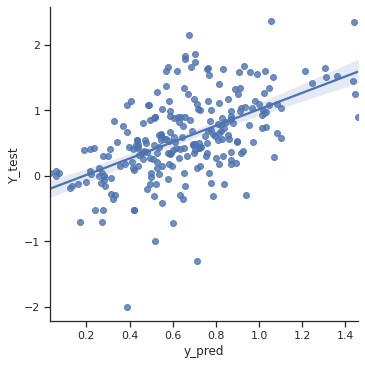

0
(994, 361)
(249, 361)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_jobs=30, random_state=46)
Calculating Permutation Importances
249
2-fold :  48.59437751004016
3-fold :  67.46987951807229
5-fold :  80.72289156626506
gmfe :  2.6940753135341358
mfe :  1.376547301429501
bias :  0.03120483373543942
rmse  0.5701848240553914
r2  0.2798302035765895


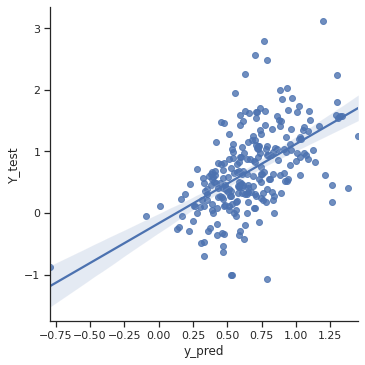

1
(994, 361)
(249, 361)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_jobs=30, random_state=46)
Calculating Permutation Importances
249
2-fold :  52.610441767068274
3-fold :  71.8875502008032
5-fold :  83.53413654618474
gmfe :  2.387272665699002
mfe :  1.3238973788892914
bias :  0.08586799155937896
rmse  0.5080704768314234
r2  0.33586316935077587


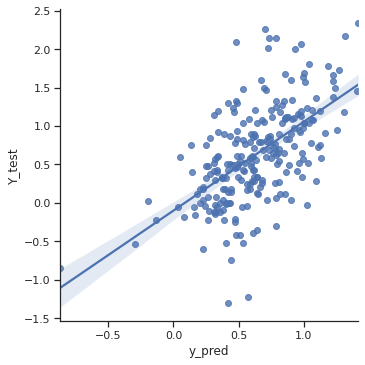

2
(994, 361)
(249, 361)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=46)
Calculating Permutation Importances
249
2-fold :  55.020080321285135
3-fold :  75.90361445783132
5-fold :  85.94377510040161
gmfe :  2.2997558375536205
mfe :  1.300434343672943
bias :  0.008297159434996093
rmse  0.49986144794554704
r2  0.32643532114530316


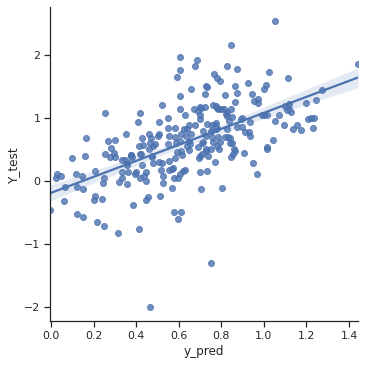

3
(995, 361)
(248, 361)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=46)
Calculating Permutation Importances
248
2-fold :  45.564516129032256
3-fold :  65.32258064516128
5-fold :  80.24193548387096
gmfe :  2.8327635000711076
mfe :  1.395179796854381
bias :  -0.07280822146841359
rmse  0.6292621776541636
r2  0.15768675457382064


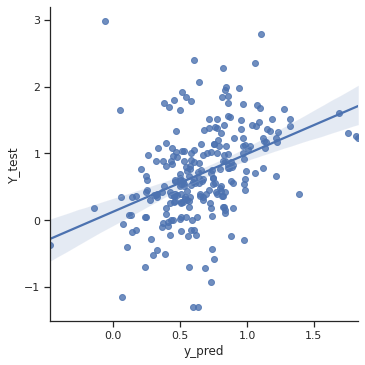

4
(995, 361)
(248, 361)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=46)
Calculating Permutation Importances
248
2-fold :  45.96774193548387
3-fold :  72.98387096774194
5-fold :  86.29032258064517
gmfe :  2.406616521870888
mfe :  1.377276765235361
bias :  0.4759862468872649
rmse  0.5070021579910703
r2  0.3015237169477206


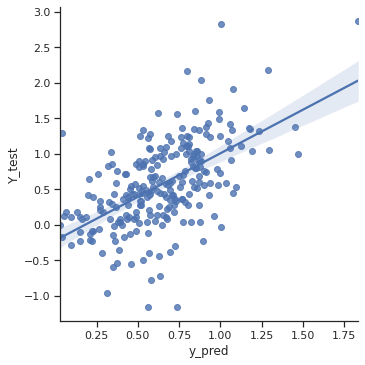

human_thalf
0
(1012, 361)
(253, 361)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=42)
Calculating Permutation Importances
253
2-fold :  47.43083003952569
3-fold :  69.1699604743083
5-fold :  84.98023715415019
gmfe :  2.5352016044061103
mfe :  1.389785156683892
bias :  -0.17967264641585734
rmse  0.5255229646305605
r2  0.2989502332491003
saving model


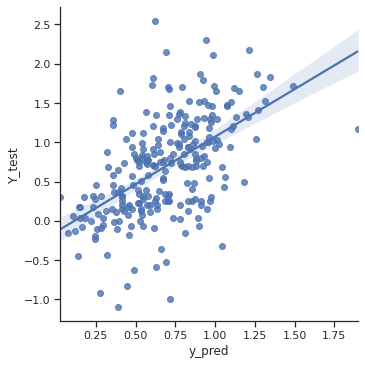

1
(1012, 361)
(253, 361)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
Calculating Permutation Importances
253
2-fold :  52.17391304347826
3-fold :  69.56521739130434
5-fold :  84.58498023715416
gmfe :  2.4393621067218554
mfe :  1.3135572111542317
bias :  0.36677754115461436
rmse  0.525726577430779
r2  0.2848588122431348
saving model


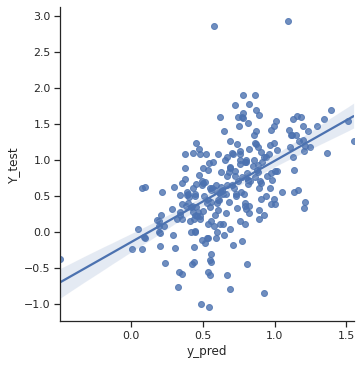

2
(1012, 361)
(253, 361)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=42)
Calculating Permutation Importances
253
2-fold :  53.359683794466406
3-fold :  75.09881422924902
5-fold :  86.95652173913044
gmfe :  2.301411508380929
mfe :  1.315459824519955
bias :  0.14010761724653986
rmse  0.4806098912595155
r2  0.32133055384156695
saving model


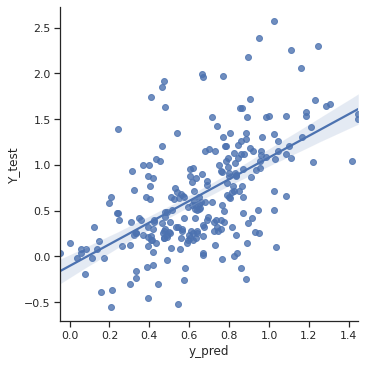

3
(1012, 361)
(253, 361)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=42)
Calculating Permutation Importances
253
2-fold :  48.22134387351779
3-fold :  67.98418972332016
5-fold :  82.21343873517787
gmfe :  2.706698892393345
mfe :  1.35616099880459
bias :  0.25711613157754143
rmse  0.5978296338977181
r2  0.26920883471126356


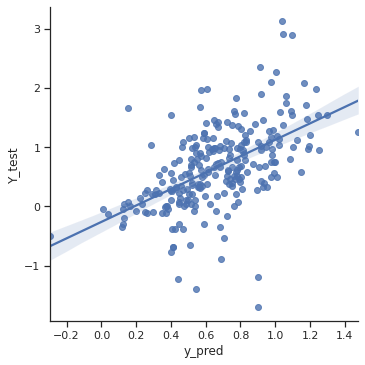

4
(1012, 361)
(253, 361)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_jobs=30, random_state=42)
Calculating Permutation Importances
253
2-fold :  55.33596837944664
3-fold :  76.28458498023716
5-fold :  88.14229249011858
gmfe :  2.1930469902050334
mfe :  1.3032457878934331
bias :  0.18843002794293406
rmse  0.45816884068830394
r2  0.3595006621266893
saving model


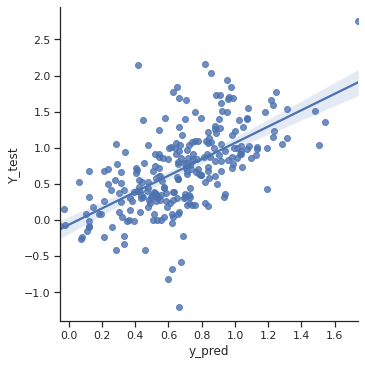

0
(1012, 361)
(253, 361)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=43)
Calculating Permutation Importances
253
2-fold :  47.43083003952569
3-fold :  71.93675889328063
5-fold :  90.11857707509881
gmfe :  2.271168839139578
mfe :  1.3687361509034812
bias :  -0.02910884700329497
rmse  0.4597199353936878
r2  0.33563968907356756


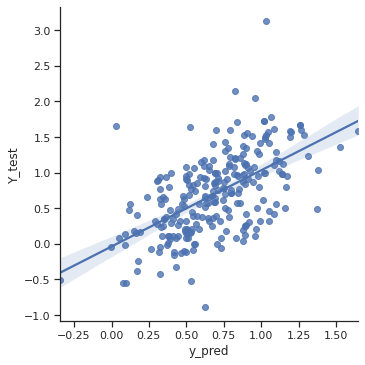

1
(1012, 361)
(253, 361)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=43)
Calculating Permutation Importances
253
2-fold :  51.38339920948617
3-fold :  69.56521739130434
5-fold :  81.81818181818183
gmfe :  2.5737290768804257
mfe :  1.3332082753404908
bias :  0.46558856553430483
rmse  0.5709100600930452
r2  0.26727140137056227


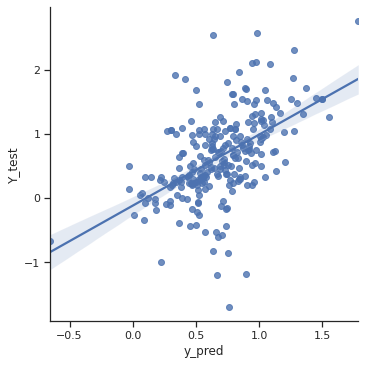

2
(1012, 361)
(253, 361)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=43)
Calculating Permutation Importances
253
2-fold :  49.80237154150198
3-fold :  70.35573122529645
5-fold :  86.16600790513834
gmfe :  2.4521123152997526
mfe :  1.3520641002426705
bias :  0.038775289333732754
rmse  0.5221078702933755
r2  0.2615690072712774


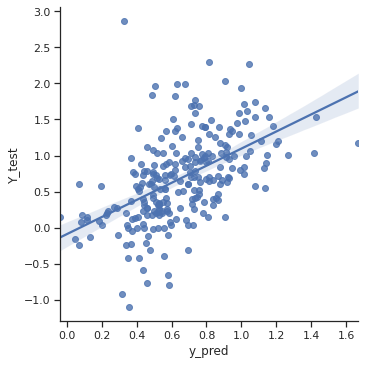

3
(1012, 361)
(253, 361)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=43)
Calculating Permutation Importances
253
2-fold :  52.17391304347826
3-fold :  69.56521739130434
5-fold :  84.58498023715416
gmfe :  2.414348999241052
mfe :  1.3376279149505843
bias :  0.06696021930132989
rmse  0.5061489789322882
r2  0.3315440453023616


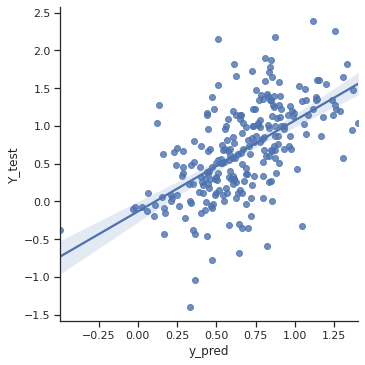

4
(1012, 361)
(253, 361)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
Calculating Permutation Importances
253
2-fold :  53.359683794466406
3-fold :  73.12252964426878
5-fold :  85.37549407114624
gmfe :  2.36956938974106
mfe :  1.3023033720785757
bias :  0.26364346039249664
rmse  0.5192433845346551
r2  0.3633541193258847


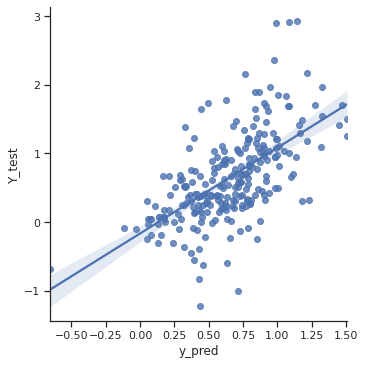

0
(1012, 361)
(253, 361)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=44)
Calculating Permutation Importances
253
2-fold :  55.73122529644269
3-fold :  77.07509881422925
5-fold :  88.93280632411067
gmfe :  2.236998154204978
mfe :  1.3003505439383072
bias :  0.06556768407832925
rmse  0.4614823142262466
r2  0.3419007825142003


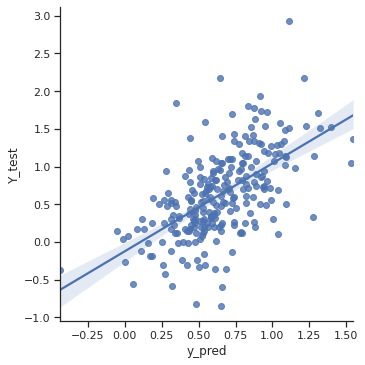

1
(1012, 361)
(253, 361)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=200, n_jobs=30, random_state=44)
Calculating Permutation Importances
253
2-fold :  47.43083003952569
3-fold :  72.72727272727273
5-fold :  86.16600790513834
gmfe :  2.531702543852836
mfe :  1.3689668518732623
bias :  0.18387951764899446
rmse  0.5371489678097793
r2  0.3139913089562757


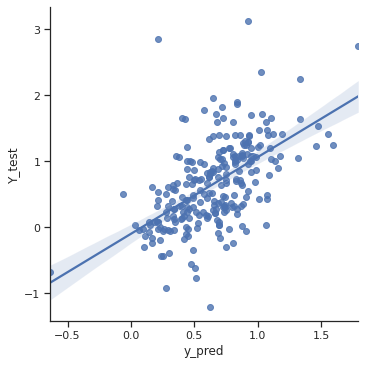

2
(1012, 361)
(253, 361)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=44)
Calculating Permutation Importances
253
2-fold :  52.17391304347826
3-fold :  70.35573122529645
5-fold :  89.32806324110672
gmfe :  2.371711026731759
mfe :  1.3322318322791793
bias :  0.3764381179779148
rmse  0.49622733503852073
r2  0.3152192943834824


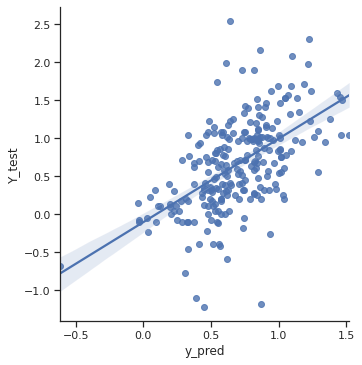

3
(1012, 361)
(253, 361)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=44)
Calculating Permutation Importances
253
2-fold :  47.03557312252965
3-fold :  67.19367588932806
5-fold :  83.399209486166
gmfe :  2.622826530388239
mfe :  1.3811385329582846
bias :  0.5136740831350455
rmse  0.5608843958928199
r2  0.2778763885944757


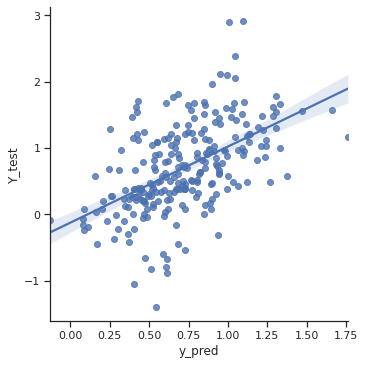

4
(1012, 361)
(253, 361)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=44)
Calculating Permutation Importances
253
2-fold :  50.59288537549407
3-fold :  69.56521739130434
5-fold :  85.37549407114624
gmfe :  2.4799919139854922
mfe :  1.32078670110241
bias :  -0.038984734983706026
rmse  0.5438185504119567
r2  0.2566509176609717


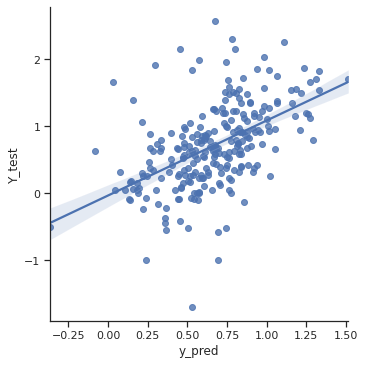

0
(1012, 361)
(253, 361)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
253
2-fold :  45.45454545454545
3-fold :  70.7509881422925
5-fold :  85.7707509881423
gmfe :  2.5367894483797406
mfe :  1.388853653171302
bias :  0.4200383678921389
rmse  0.540098283009094
r2  0.25343276347932864


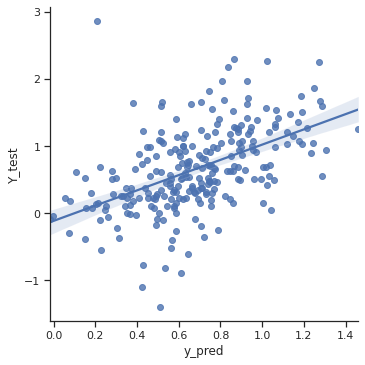

1
(1012, 361)
(253, 361)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=45)
Calculating Permutation Importances
253
2-fold :  50.988142292490124
3-fold :  70.35573122529645
5-fold :  88.53754940711462
gmfe :  2.3111125323543154
mfe :  1.3439075215784693
bias :  0.19324855774992944
rmse  0.4719506631551187
r2  0.31643821192360666


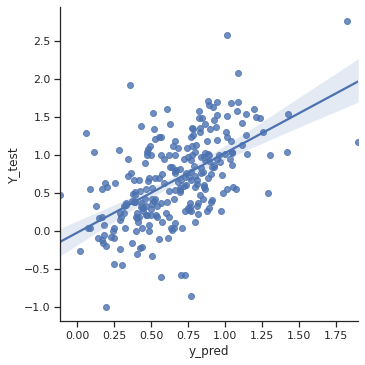

2
(1012, 361)
(253, 361)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=45)
Calculating Permutation Importances
253
2-fold :  52.96442687747036
3-fold :  75.09881422924902
5-fold :  85.37549407114624
gmfe :  2.450294562627917
mfe :  1.3234707167700073
bias :  -0.12498805157439596
rmse  0.5499278079692953
r2  0.26932742773880913


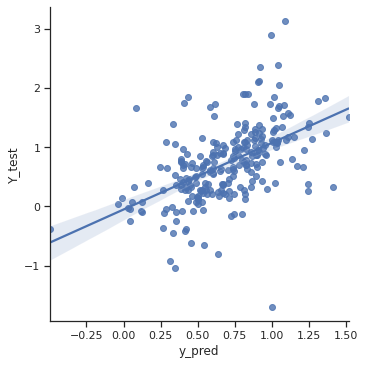

3
(1012, 361)
(253, 361)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
253
2-fold :  49.40711462450593
3-fold :  71.14624505928853
5-fold :  83.00395256916995
gmfe :  2.5449054402143596
mfe :  1.3534594155358728
bias :  0.3277092557985397
rmse  0.5434201297278124
r2  0.297300342125832


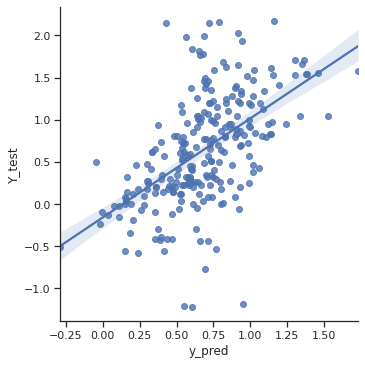

4
(1012, 361)
(253, 361)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
253
2-fold :  51.38339920948617
3-fold :  74.30830039525692
5-fold :  86.16600790513834
gmfe :  2.366010385632739
mfe :  1.3302885377583316
bias :  0.2453804728125708
rmse  0.49860153658057826
r2  0.35604363292679


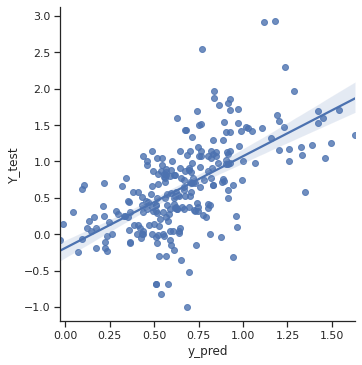

0
(1012, 361)
(253, 361)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=46)
Calculating Permutation Importances
253
2-fold :  45.45454545454545
3-fold :  67.58893280632411
5-fold :  83.00395256916995
gmfe :  2.611053277534211
mfe :  1.4093997757537484
bias :  -0.22134220013041928
rmse  0.5535334039627163
r2  0.19567599530545843


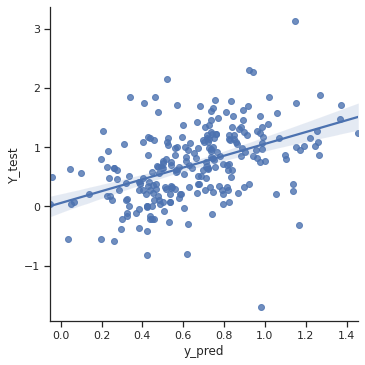

1
(1012, 361)
(253, 361)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=46)
Calculating Permutation Importances
253
2-fold :  51.38339920948617
3-fold :  77.86561264822134
5-fold :  88.53754940711462
gmfe :  2.2297061143211896
mfe :  1.3308930284946365
bias :  0.10671333494513546
rmse  0.46273950354436144
r2  0.33487747812233126


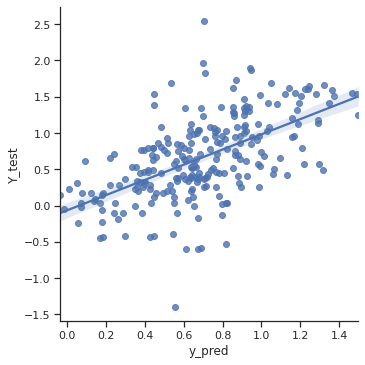

2
(1012, 361)
(253, 361)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=200, n_jobs=30,
                      random_state=46)
Calculating Permutation Importances
253
2-fold :  52.17391304347826
3-fold :  71.93675889328063
5-fold :  84.58498023715416
gmfe :  2.3793893848299446
mfe :  1.3125314280161684
bias :  0.31256058283813526
rmse  0.5108099268348417
r2  0.28928990574337243


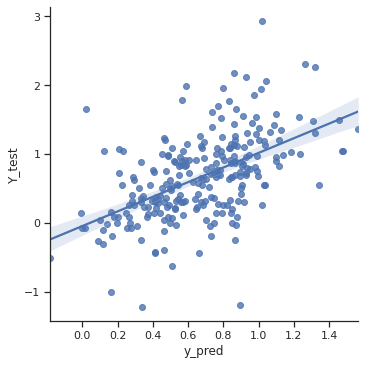

3
(1012, 361)
(253, 361)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=200, n_jobs=30,
                      random_state=46)
Calculating Permutation Importances
253
2-fold :  50.59288537549407
3-fold :  66.79841897233202
5-fold :  83.399209486166
gmfe :  2.5807504197590285
mfe :  1.347690606586839
bias :  0.3220716349668342
rmse  0.5578926006575325
r2  0.330096782989002


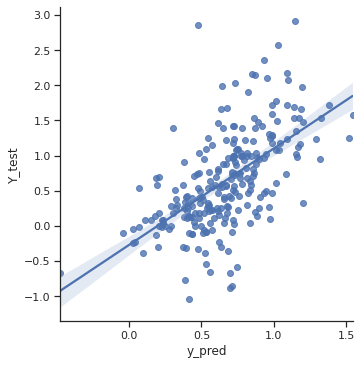

4
(1012, 361)
(253, 361)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=46)
Calculating Permutation Importances
253
2-fold :  51.77865612648221
3-fold :  70.35573122529645
5-fold :  86.16600790513834
gmfe :  2.4026489100800235
mfe :  1.3365902014493916
bias :  0.2060774986665468
rmse  0.5152265164140843
r2  0.343124063143158


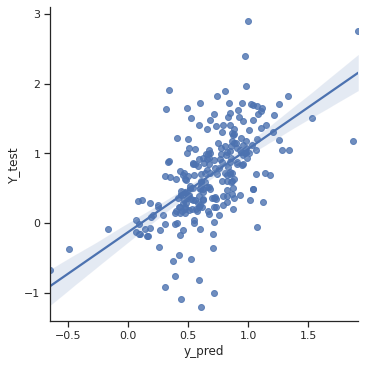

In [22]:
from sklearn.preprocessing import StandardScaler
import pickle
list_of_lists=[]
detail_list_batch=[]
model_parameters_batch=[]


for endpoint in ["human_VDss_L_kg","human_CL_mL_min_kg", "human_fup", "human_mrt", "human_thalf"]:

    data = human_lombardo_mfp_Mordred_animal
    features = features_mordred_animal_columns
    baseline=10.00

    print(endpoint)    
    df = data.dropna(subset=[endpoint]).reset_index(drop=True)

    X = df[features]
    Y = df[endpoint]
    
    # Scale the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X = pd.DataFrame(X, columns=features)
    
    #Nested Cross Validation    
    for i in range(42, 47):
        
        outercv = KFold(n_splits=5, random_state=i, shuffle=True) 

        for split, (train_index, test_index) in enumerate(outercv.split(X)):
            
            print(split)
            train = df.iloc[train_index]
            X_train= X.iloc[train_index].values
            Y_train= Y.iloc[train_index].values.flatten()

            test = df.iloc[test_index]
            X_test= X.iloc[test_index].values
            Y_test= Y.iloc[test_index].values.flatten()

            print(X_train.shape)
            print(X_test.shape)

            inner_cv = KFold(n_splits=4, random_state=i, shuffle=True) 

            # Create a based model
            regressor = RandomForestRegressor(random_state = i, n_jobs=20)

            # Instantiate the RandomHalving search model
            param_grid = { 
            "n_estimators": [100,200,300],
            "max_features": ["sqrt", "log2"],
            "min_samples_split": [2,4,8],
            "max_depth": [5, 10, 15],    
            "bootstrap": [True, False],
            'n_jobs': [30]
            }

            gsh = GridSearchCV(estimator = regressor, param_grid = param_grid, cv = inner_cv, n_jobs=30, verbose = 1)

            ##MODELS
            print(f"Running ____________________{endpoint} MODELS")

            gsh.fit(X_train, Y_train)
            #print(gsh.best_estimator_)

            #HeldOutTest
            classifier = gsh.best_estimator_
            print(classifier)
            
            row=[endpoint, i, split, classifier.n_estimators, classifier.max_features,
                classifier.min_samples_split, classifier.max_depth, classifier.bootstrap]
            model_parameters_batch.append(row)
            
            
            classifier.fit(X_train, Y_train)

            print("Calculating Permutation Importances")  
            y_pred =  classifier.predict(X_test)     
            print(len(y_pred))

            fold_2= count(y_pred, Y_test, 0.5, 2, endpoint)
            fold_3= count(y_pred, Y_test, 1/3, 3, endpoint)
            fold_5= count(y_pred, Y_test, 1/5, 5, endpoint)
            gmfe = calc_gmfe(y_pred, Y_test, endpoint)
            mfe = median_fold_change_error(y_pred, Y_test, endpoint)
            bias = calc_bias(y_pred, Y_test, endpoint)

            print("2-fold : ", fold_2)
            print("3-fold : ", fold_3)
            print("5-fold : ", fold_5)
            print("gmfe : ", gmfe)
            print("mfe : ", mfe)
            print("bias : ", bias)

            rmse = sqrt(mean_squared_error(Y_test, y_pred))
            print('rmse ',rmse)
            r2 = r2_score(Y_test, y_pred)
            print('r2 ',r2)

            if (gmfe<baseline):
                # save
                print("saving model")
                baseline=gmfe
                pickle.dump(classifier, open(f"log_{endpoint}_mrd_withanimaldata_artificial_model.sav",  'wb'))

            sns.set_theme(style="ticks")
            df_plot=pd.DataFrame({"y_pred":y_pred, "Y_test":Y_test})
            sns.lmplot(data=df_plot, x="y_pred", y="Y_test")
            plt.show()

            row=["HeldOut",  endpoint, i, split, fold_2, fold_3, fold_5, gmfe, mfe, bias, rmse, r2]
            list_of_lists.append(row)
            
            #combine results
            for smiles_r, pred, true in zip(test.smiles_r, y_pred, Y_test):
                detail_list_batch.append([endpoint, i, split, smiles_r, pred, true])


In [23]:
model_parameters= pd.DataFrame(model_parameters_batch,columns=["endpoint", "random_state", 
                                                            "split", "n_estimators", "max_features",
                "min_samples_split", "max_depth", "bootstrap"])
model_parameters

endpoint  random_state  split  n_estimators max_features  \
0    human_VDss_L_kg            42      0           300         sqrt   
1    human_VDss_L_kg            42      1           100         sqrt   
2    human_VDss_L_kg            42      2           200         sqrt   
3    human_VDss_L_kg            42      3           300         sqrt   
4    human_VDss_L_kg            42      4           300         sqrt   
..               ...           ...    ...           ...          ...   
120      human_thalf            46      0           200         sqrt   
121      human_thalf            46      1           300         sqrt   
122      human_thalf            46      2           200         sqrt   
123      human_thalf            46      3           200         sqrt   
124      human_thalf            46      4           200         sqrt   

     min_samples_split  max_depth  bootstrap  
0                    4         15      False  
1                    4         15      False  
2                    4         15      False  
3                    8         15      False  
4                    2         15      False  
..                 ...        ...        ...  
120                  2         15      False  
121                  2         15      False  
122                  8         15      False  
123                  8         15      False  
124                  2         15      False  

[125 rows x 8 columns]

In [24]:
detail_list = pd.DataFrame(detail_list_batch,columns=["endpoint", "random_state", 
                                                           "split", "smiles_r", "pred", "true"])
detail_list["key"] =  detail_list["endpoint"].astype(str) + detail_list["smiles_r"].astype(str) + detail_list["random_state"].astype(str)+ detail_list["split"].astype(str)
detail_list

endpoint  random_state  split  \
0      human_VDss_L_kg            42      0   
1      human_VDss_L_kg            42      0   
2      human_VDss_L_kg            42      0   
3      human_VDss_L_kg            42      0   
4      human_VDss_L_kg            42      0   
...                ...           ...    ...   
29580      human_thalf            46      4   
29581      human_thalf            46      4   
29582      human_thalf            46      4   
29583      human_thalf            46      4   
29584      human_thalf            46      4   

                                                smiles_r      pred      true  \
0      C#C[C@]1(O)CC[C@H]2[C@@H]3CCc4cc([O-])ccc4[C@H...  0.246065  0.633468   
1      C=C(CC(NC(=O)c1ccc(CCc2cnc3nc(N)nc(N)c3n2)cc1)... -0.070289 -0.154902   
2      C=CC1=C(C(=O)[O-])[NH+]2C(=O)C(=NC(=O)C(NOCC(=... -0.726204 -0.619789   
3                         C=CCc1ccccc1OCC(O)C[NH2+]C(C)C  0.366153  0.505150   
4      C=C[C@@H]1C[C@]1(NC(=O)C1C[C@@H](Oc2ncc(OC)c3c... -0.010654  0.442480   
...                                                  ...       ...       ...   
29580  [NH3+]CCCCC(NC(=O)C(Cc1cc(Br)c([O-])c(Br)c1)NC...  0.931661  0.397940   
29581                 [NH3+]C[C@H]1OB(O)c2c(OCCCO)cccc21  0.557228  1.064458   
29582                [O-]c1ccc(C2=Cc3ccc([O-])cc3OC2)cc1  0.432432 -0.173925   
29583  [O-]c1ccc([C@H]2C[NH2+]CCc3c2cc([O-])c([O-])c3...  0.545657  0.000000   
29584                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1  0.881728  0.359835   

                                                     key  
0      human_VDss_L_kgC#C[C@]1(O)CC[C@H]2[C@@H]3CCc4c...  
1      human_VDss_L_kgC=C(CC(NC(=O)c1ccc(CCc2cnc3nc(N...  
2      human_VDss_L_kgC=CC1=C(C(=O)[O-])[NH+]2C(=O)C(...  
3       human_VDss_L_kgC=CCc1ccccc1OCC(O)C[NH2+]C(C)C420  
4      human_VDss_L_kgC=C[C@@H]1C[C@]1(NC(=O)C1C[C@@H...  
...                                                  ...  
29580  human_thalf[NH3+]CCCCC(NC(=O)C(Cc1cc(Br)c([O-]...  
29581   human_thalf[NH3+]C[C@H]1OB(O)c2c(OCCCO)cccc21464  
29582  human_thalf[O-]c1ccc(C2=Cc3ccc([O-])cc3OC2)cc1464  
29583  human_thalf[O-]c1ccc([C@H]2C[NH2+]CCc3c2cc([O-...  
29584  human_thalfc1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1464  

[29585 rows x 7 columns]

In [25]:
results = pd.DataFrame(list_of_lists, columns=["HeldOut", "endpoint", "random_state", "split", "fold_2", "fold_3", "fold_5", "gmfe", "mfe", "bias", "rmse", "r2"])
results

HeldOut         endpoint  random_state  split     fold_2     fold_3  \
0    HeldOut  human_VDss_L_kg            42      0  56.800000  74.400000   
1    HeldOut  human_VDss_L_kg            42      1  58.800000  75.600000   
2    HeldOut  human_VDss_L_kg            42      2  57.200000  73.600000   
3    HeldOut  human_VDss_L_kg            42      3  59.600000  75.600000   
4    HeldOut  human_VDss_L_kg            42      4  54.618474  75.100402   
..       ...              ...           ...    ...        ...        ...   
120  HeldOut      human_thalf            46      0  45.454545  67.588933   
121  HeldOut      human_thalf            46      1  51.383399  77.865613   
122  HeldOut      human_thalf            46      2  52.173913  71.936759   
123  HeldOut      human_thalf            46      3  50.592885  66.798419   
124  HeldOut      human_thalf            46      4  51.778656  70.355731   

        fold_5      gmfe       mfe      bias      rmse        r2  
0    89.600000  2.141135  1.289893  0.023746  0.440464  0.550351  
1    90.000000  2.070423  1.258785  0.073946  0.410490  0.548666  
2    86.000000  2.207488  1.249665  0.000147  0.474249  0.482218  
3    89.200000  2.088100  1.270774  0.006380  0.425218  0.568267  
4    89.959839  2.187582  1.314290  0.075202  0.446412  0.483487  
..         ...       ...       ...       ...       ...       ...  
120  83.003953  2.611053  1.409400 -0.221342  0.553533  0.195676  
121  88.537549  2.229706  1.330893  0.106713  0.462740  0.334877  
122  84.584980  2.379389  1.312531  0.312561  0.510810  0.289290  
123  83.399209  2.580750  1.347691  0.322072  0.557893  0.330097  
124  86.166008  2.402649  1.336590  0.206077  0.515227  0.343124  

[125 rows x 12 columns]

In [26]:
model_parameters.to_csv("model_parameters_Prediction_human_from_mordred_fs_animal_artificial.csv", index=False)

In [27]:
detail_list.to_csv("detail_list_Prediction_human_from_mordred_fs_animal_artificial.csv", index=False)

In [28]:
results.to_csv("Prediction_human_from_mordred_fs_animal_artificial.csv", index=False)

In [29]:
import pandas as pd
results= pd.read_csv("Prediction_human_from_mordred_fs_animal_artificial.csv")
results.groupby("endpoint").mean().reset_index().to_csv("human_with_mordred_animal_artificial.csv", index=False)
results.groupby("endpoint").mean()

random_state  split     fold_2     fold_3     fold_5  \
endpoint                                                                   
human_CL_mL_min_kg          44.0    2.0  50.632721  70.100985  84.480058   
human_VDss_L_kg             44.0    2.0  57.437944  75.213044  89.176353   
human_fup                   44.0    2.0  55.221948  67.918442  78.474935   
human_mrt                   44.0    2.0  50.008615  70.635186  83.362612   
human_thalf                 44.0    2.0  50.608696  71.430830  85.707510   

                        gmfe       mfe      bias      rmse        r2  
endpoint                                                              
human_CL_mL_min_kg  2.490320  1.343582 -0.213405  0.542496  0.296475  
human_VDss_L_kg     2.132578  1.280025  0.033017  0.437683  0.529974  
human_fup           2.740034  1.280540  0.037973  0.209099  0.619414  
human_mrt           2.509631  1.349888  0.070203  0.544208  0.275404  
human_thalf         2.436502  1.342108  0.178666  0.518790  0.303379

In [30]:
# load
loaded_rf = pickle.load(open("log_human_VDss_L_kg_mrd_withanimaldata_artificial_model.sav", 'rb'))